# Predicción de Exitus (fallecimiento). Comparativa final

In [1]:
# Load Libraries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd 
import multiprocessing
import random
from sklearn.metrics import roc_auc_score as metric
import seaborn as sns
from matplotlib import pyplot as plt




from sklearn.preprocessing import scale
from sklearn.preprocessing import OneHotEncoder
import timeit

## Dataset

Leamos el dataset a utilizar.

In [2]:
# Load the dataset 
X = pd.read_csv("datasets/dat_sanidad_raw.csv", sep='|', decimal=',', encoding='latin-1')
X.shape

(32706, 10)

El dataset consta de:

- 32706 **filas** o instancias
- 10 **columnas** o variables.

Veamos su contenido.

In [3]:
X.head()

,gravedad,pct_mortalidad_norma,edad_dias,numproc,potencial_ambul,proc,estancia_esperada,tipgrd,tiping,exitus
0,4,0.408730,12596.0,21,0,1,NaN,Q,1,0
1,4,NaN,20973.0,22,0,1,99.0,Q,1,0
2,4,0.278481,19611.0,19,0,1,NaN,Q,1,0
3,3,0.150289,13583.0,22,0,1,100.0,Q,1,0
4,1,0.016573,18042.0,2,0,1,NaN,Q,1,0


- **gravedad**: Gravedad dentro del GRD. Valores de 1 a 4: Categorica

- **pct_mortalidad_norma**: Tasa de mortalidad histórica para ese GRD: Numérica
        
- **edad_dias**: Edad en días del paciente: Numérica

- **numproc**: Número de procedimientos que se han llevado a cabo al paciente a las 24 horas: Numérica
    
- **potencial_ambul**: Flag (valor 0 = no / 1 = sí) que indica si el caso se ha catalogado como potencialmente ambulatorio, es decir, no requiere ingreso: Categórica
    
- **proc**: Procedencia del paciente. Categórica

- **estancia_esperada**: Número de días que se espera que el paciente esté ingresado en el hospital por este episodio asistencial: Numérica

- **tipgrd**: GRD médico (M) o de quirófano (Q): Categórica
    
- **tiping**: Tipo de ingreso: Programado, urgente...: Categórica
    
- **exitus**: 1 = El paciente falleció: Categórica

De estas variables, fecing la usaremos para realizar el split en train/validacion/test, exitus es el target y las 10 variables restantes serán el input de nuestro modelo.

## Exploratorio

In [4]:
# Cambiamos el tipo de datos
X.describe(include='all')

,gravedad,pct_mortalidad_norma,edad_dias,numproc,potencial_ambul,proc,estancia_esperada,tipgrd,tiping,exitus
count,32706.000000,29399.000000,32232.000000,32706.000000,32706.000000,32706.000000,5127.000000,32706,32706.000000,32706.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,M,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23137,NaN,NaN
mean,1.623800,0.030175,19237.308265,4.074940,0.062649,1.532043,4.806319,NaN,1.271510,0.038403
std,0.930471,0.066510,9314.861421,2.819762,0.242334,1.371549,6.079437,NaN,0.474676,0.192169
min,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,NaN,1.000000,0.000000
25%,1.000000,0.000000,12350.000000,2.000000,0.000000,1.000000,2.000000,NaN,1.000000,0.000000
50%,1.000000,0.001095,19914.500000,3.000000,0.000000,1.000000,3.000000,NaN,1.000000,0.000000
75%,2.000000,0.028365,26936.250000,5.000000,0.000000,2.000000,6.000000,NaN,2.000000,0.000000


In [5]:
X.dtypes

gravedad                  int64
pct_mortalidad_norma    float64
edad_dias               float64
numproc                   int64
potencial_ambul           int64
proc                      int64
estancia_esperada       float64
tipgrd                   object
tiping                    int64
exitus                    int64
dtype: object

In [6]:
# Casos de exitus en porcentaje
100 * np.sum(X['exitus'] == 1) / X.shape[0]

3.8402739558490797

## Pre-procesado

### Fill missing values

Porcentaje de missing values para cada variable

In [7]:
X.apply(lambda x: 100*np.sum(x.isna())/len(x))

gravedad                 0.000000
pct_mortalidad_norma    10.111295
edad_dias                1.449275
numproc                  0.000000
potencial_ambul          0.000000
proc                     0.000000
estancia_esperada       84.323977
tipgrd                   0.000000
tiping                   0.000000
exitus                   0.000000
dtype: float64

* **estancia_esperada**: supondremos que los missing values corresponden a que se espera que el paciente pase 0 días ingresado


In [8]:
X['estancia_esperada'] = X['estancia_esperada'].fillna(0)

* **edad_dias**: rellenamos los missing values con la media


In [9]:
media_edad = X['edad_dias'].mean()
X['edad_dias'] = X['edad_dias'].fillna(media_edad)

* **pct_mortalidad_norma**: rellenamos missing values con la media de pct_mortalidad_norma para cada grupo de gravedad, ya que dependiendo del grupo este valor varia bastante

In [10]:
# Vemos el valor medio de pct_mortalidad_norma para cada valor de gravedad
gravedades = X['gravedad'].unique()

for gravedad in gravedades:
    print(f"media pct_mortalidad_norma para gravedad {gravedad}")
    print(X[X['gravedad'] == gravedad]['pct_mortalidad_norma'].mean())

media pct_mortalidad_norma para gravedad 4
0.20891454690759004
media pct_mortalidad_norma para gravedad 3
0.08817547022181497
media pct_mortalidad_norma para gravedad 1
0.00142383499085708
media pct_mortalidad_norma para gravedad 2
0.02847451930646185


In [11]:
medias = X[['gravedad', 'pct_mortalidad_norma']].groupby('gravedad').mean()

X['pct_mortalidad_norma'] = X['pct_mortalidad_norma'].fillna(X['gravedad'].map(medias['pct_mortalidad_norma']))

Comprobamos que ya no tenemos missing values en nuestro dataset

In [12]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32706 entries, 0 to 32705
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   gravedad              32706 non-null  int64  
 1   pct_mortalidad_norma  32706 non-null  float64
 2   edad_dias             32706 non-null  float64
 3   numproc               32706 non-null  int64  
 4   potencial_ambul       32706 non-null  int64  
 5   proc                  32706 non-null  int64  
 6   estancia_esperada     32706 non-null  float64
 7   tipgrd                32706 non-null  object 
 8   tiping                32706 non-null  int64  
 9   exitus                32706 non-null  int64  
dtypes: float64(3), int64(6), object(1)
memory usage: 2.5+ MB


### One-Hot Encoding

Utilizaremos la técnica de one-hot encoding.

<img src="../figures/oh.png" width="50%">

Seleccionemos las variables categóricas en primer lugar.

In [13]:
categorical_vars = set(['gravedad', 'proc', 'tiping', 'tipgrd'])
numerical_vars = set(X.columns) - categorical_vars
categorical_vars = list(categorical_vars)
numerical_vars = list(numerical_vars)

In [14]:
print(categorical_vars)
print(numerical_vars)

['gravedad', 'proc', 'tipgrd', 'tiping']
['pct_mortalidad_norma', 'estancia_esperada', 'exitus', 'edad_dias', 'potencial_ambul', 'numproc']


Realizamos one hot encoding de las variables categoricas

In [15]:
ohe = OneHotEncoder(sparse = False)
ohe_fit = ohe.fit(X[categorical_vars])
X_ohe = pd.DataFrame(ohe.fit_transform(X[categorical_vars]))
X_ohe.columns = pd.DataFrame(ohe_fit.get_feature_names_out())
X = pd.concat((X_ohe, X[numerical_vars].reset_index()), axis=1)
del X['index']

### Tipificar

Ahora vamos a tipificar los datos, es decir, llevarlos a media 0 y desviación estándar 1.

<img src="../figures/tipify.png" width="50%">

In [16]:
y = X['exitus'] # target
del X['exitus']
X_scale = pd.DataFrame(scale(X))
X_scale.columns = X.columns
X = X_scale
X.columns = X_scale.columns
print(X.head())

   (gravedad_1,)  (gravedad_2,)  (gravedad_3,)  (gravedad_4,)  (proc_1,)  \
0      -1.322185      -0.435743      -0.417921       4.120705   0.589002   
1      -1.322185      -0.435743      -0.417921       4.120705   0.589002   
2      -1.322185      -0.435743      -0.417921       4.120705   0.589002   
3      -1.322185      -0.435743       2.392797      -0.242677   0.589002   
4       0.756324      -0.435743      -0.417921      -0.242677   0.589002   

   (proc_2,)  (proc_3,)  (proc_4,)  (proc_6,)  (proc_7,)  ...  (tipgrd_M,)  \
0  -0.471911  -0.128712  -0.140259  -0.118114  -0.009578  ...    -1.554964   
1  -0.471911  -0.128712  -0.140259  -0.118114  -0.009578  ...    -1.554964   
2  -0.471911  -0.128712  -0.140259  -0.118114  -0.009578  ...    -1.554964   
3  -0.471911  -0.128712  -0.140259  -0.118114  -0.009578  ...    -1.554964   
4  -0.471911  -0.128712  -0.140259  -0.118114  -0.009578  ...    -1.554964   

   (tipgrd_Q,)  (tiping_1,)  (tiping_2,)  (tiping_3,)  pct_mortalidad_norm

### Split en Train/Validación/Test

Utilizaremos a modo de ejemplo los ratios habitualmente recomendados:

• Train: 70%.

• Validación: 15%.

• Test: 15%.


In [17]:
perc_values = [0.7, 0.15, 0.15];

Creamos los conjuntos de train, validacion y test con el tamaño seleccionado.

In [18]:
# dimensiones de los conjuntos de train y test
n_train = int(X.shape[0] * perc_values[0])
n_val = int(X.shape[0] * perc_values[1])
n_test = int(X.shape[0] * perc_values[2])

# selección del conjunto de train
X_train = X.iloc[:n_train]
y_train = y.iloc[:n_train]

# selección del conjunto de validación
X_val = X.iloc[(n_train):(n_train+n_val)]
y_val = y.iloc[(n_train):(n_train+n_val)]

# selección del conjunto de test
X_test = X.iloc[(n_train+n_val):]
y_test = y.iloc[(n_train+n_val):]

Visualizamos el tamaño de los 3 subdatasets

In [19]:
print('Train data size = ' + str(X_train.shape))
print('Train target size = ' + str(y_train.shape))
print('Validation data size = ' + str(X_val.shape))
print('Validation target size = ' + str(y_val.shape))
print('Test data size = ' + str(X_test.shape))
print('Test target size = ' + str(y_test.shape))

Train data size = (22894, 22)
Train target size = (22894,)
Validation data size = (4905, 22)
Validation target size = (4905,)
Test data size = (4907, 22)
Test target size = (4907,)


# Grid Search

Vamos a proceder a realizar un grid search que compare todos los modelos de clasificación que hemos visto, es decir:

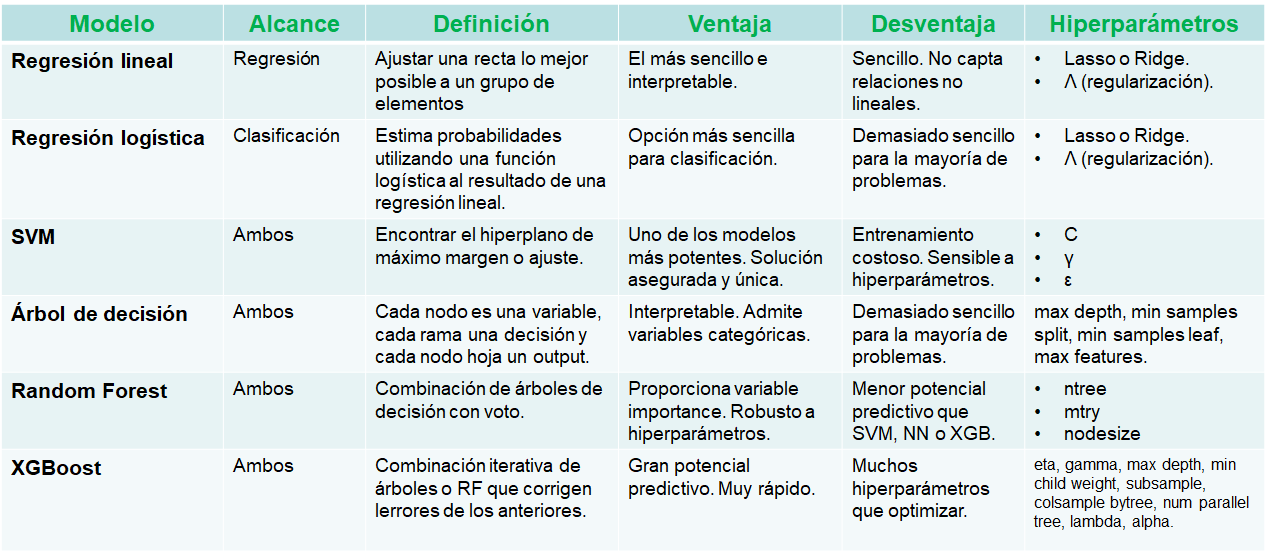

Importamos todos los modelos que vamos a usar.

In [20]:
from sklearn.linear_model import LinearRegression # Regresión lineal
from sklearn.linear_model import LogisticRegression # Regresión logística
from sklearn.svm import SVC #svm
from sklearn.tree import DecisionTreeClassifier # Arbol de decisión
from sklearn.ensemble import RandomForestClassifier # Random Forest
from xgboost import XGBClassifier # XGBoost

In [ ]:
XGBClassifier?

Importamos la métrica.

In [21]:
from sklearn.metrics import roc_auc_score as metric;

Definimos algunos parámetros generales.

In [22]:
random_state = 1;
n_estimators = 10
nthread = multiprocessing.cpu_count() - 1;
scale_pos_weight = sum(y_train == 0) / sum(y_train == 1);

Vamos a calcular los puntos recomendados por Cherkassky para la SVM.

In [23]:
n = X_train.shape[0];
d = X_train.shape[1];
m = np.mean(y_train);
s = np.std(y_train);
C_cherk = np.max([np.abs(m + 3*s),np.abs(m - 3*s)]);
gamma_cherk = np.power(0.2, 1/d)

Definimos el grid a llevar a cabo

In [25]:
# Regresion Logística
regularization_values = ['l1', 'l2', 'none'];
penalty_values = [1, 10, 100];

# SVM
C_values = [C_cherk, 5e-03, 4.5e-03, 4e-03];
gamma_kernel_values = [gamma_cherk, 3.26e-09, 3.255e-09, 3.25e-09];

# Arbol de Decision
max_depth_values = [None, 6, 20];
min_samples_split_values = [2, 5, 20];
min_samples_leaf_values = [1, 5, 20];
max_features_values = [None, 1, 2];


# Random Forest
ntrees_values = [10, 50, 100]
max_depth_values = [10,  100, None]
min_samples_split_values = [2, 4, 12]
min_samples_leaf_values = [1, 2, 4]
max_features_values = [None, 0.01]

# Xgboost
nrounds_values = [2, 10]
eta_values = [0.3, 0.99]
gamma_values = [0, 1]
max_depth_values = [6, 20]
min_child_weight_values = [1, 20]
subsample_values = [0.1, 1]
colsample_bytree_values = [0.1, 1]
num_parallel_tree_values = [1, 20]
lambda_values = [0, 1]
alpha_values = [0, 1]

In [26]:
params_values = [{'model': 'logistic regression',
                  'regularization': regularization_values,
                 'penalty': penalty_values},
                 {'model': 'svm',
                  'C': C_values,
                 'gamma_kernel': gamma_kernel_values},
                 {'model': 'decision tree',
                 'max_depth': max_depth_values,
                 'min_samples_split': min_samples_split_values,
                 'min_samples_leaf': min_samples_leaf_values,
                 'max_features': max_features_values},
                 {'model': 'random forest',
                  'n_trees': ntrees_values,
                 'max_depth': max_depth_values,
                 'min_samples_split': min_samples_split_values,
                 'min_samples_leaf': min_samples_leaf_values,
                 'max_features': max_features_values},
                 {'model': 'xgboost',
                  'nrounds': nrounds_values,
                  'eta': eta_values,
                 'gamma': gamma_values,
                 'max_depth': max_depth_values,
                 'min_child_weight': min_child_weight_values,
                 'subsample': subsample_values,
                 'colsample_bytree': colsample_bytree_values,
                 'num_parallel_tree': num_parallel_tree_values,
                 'lambda': lambda_values,
                 'alpha': alpha_values}]

In [27]:
total_iteraciones = 0
for params in params_values:
    if params['model'] == 'logistic regression':
        n = len(params['regularization'])*len(params['penalty'])
    elif params['model'] == 'svm':
        n = len(params['C'])*len(params['gamma_kernel'])
    elif params['model'] == 'decision tree':
        n = len(params['max_depth'])*len(params['min_samples_split'])*len(params['min_samples_leaf'])*len(params['max_features'])
    elif params['model'] == 'random forest':
        n = len(params['n_trees'])*len(params['max_depth'])*len(params['min_samples_split'])*len(params['min_samples_leaf'])*len(params['max_features'])
    elif params['model'] == 'xgboost':
        n = len(params['nrounds'])*len(params['eta'])*len(params['gamma'])*len(params['max_depth'])*len(params['min_child_weight'])*len(params['subsample'])*len(params['colsample_bytree'])*len(params['num_parallel_tree'])*len(params['lambda'])*len(params['alpha'])
    total_iteraciones = total_iteraciones + n;
    print(str(n)+ ' iteraciones de ' + str(params['model']))
print(str(total_iteraciones)+ ' iteraciones en total')        

9 iteraciones de logistic regression
16 iteraciones de svm
36 iteraciones de decision tree
108 iteraciones de random forest
1024 iteraciones de xgboost
1193 iteraciones en total


Ejecutamos el grid.

In [28]:
# Mirar time

grid_results = pd.DataFrame();
num_iter = 0
for params in params_values:   
    
    # Logistic Regression
    if params['model'] == 'logistic regression':
        for regularization in params['regularization']:
            for penalty in params['penalty']:  
                start = timeit.default_timer()
                
                # Actualizar contador
                num_iter += 1; 
                
                # print control iteracion modelo
                print('Inicio de iteracion ' + str(num_iter) + 
                      '. Regularizacion = ' + str(regularization) + 
                      ', Lambda = '  + str(penalty) +
                      '\n')
                
                # Entrenar modelo
                if regularization == 'l1':
                    model = LogisticRegression(penalty = regularization, 
                                               solver = 'liblinear', 
                                               C = penalty, 
                                               random_state = random_state)
                else:
                    model = LogisticRegression(penalty = regularization,
                                               solver = 'lbfgs', 
                                               C = penalty, 
                                               random_state = random_state)
               
                model.fit(X_train, np.array(y_train))

                # Generar predicciones
                pred_train_p = model.predict_proba(X_train)
                pred_val_p = model.predict_proba(X_val)

                # Calcular métricas de evaluación
                auc_train = metric(y_train, pred_train_p[:, 1])
                auc_val = metric(y_val, pred_val_p[:, 1])
                time = timeit.default_timer() - start

                print('Fin de iteracion ' + str(num_iter) + 
                     '. Regularizacion = ' + str(regularization) + 
                      ', Lambda = '  + str(penalty) +
                      '. AUC train = '  + str(auc_train) + 
                      ' -  AUC val = '  + str(auc_val)  + 
                      ' -  time = '  + str(time)  +
                      '\n')
                grid_results = grid_results.append(pd.DataFrame(data={'model':'Logistic Regression',
                                                                      'params': [{'regularization':[regularization],
                                                                                  'penalty':[penalty]}],
                                                                      'auc_train':[auc_train],
                                                                      'auc_val':[auc_val],
                                                                      'time':[time]},
                                                               columns=['model','params', 'auc_train', 'auc_val', 'time']), 
                                                   ignore_index=True)
                
    # SVM
    if params['model'] == 'svm':
        for C in params['C']:
            for gamma_kernel in params['gamma_kernel']:  
                start = timeit.default_timer()
                
                # Actualizar contador
                num_iter += 1; 
                
                # print control iteracion modelo
                print('Inicio de iteracion ' + str(num_iter) + 
                      '. C = ' + str(C) + 
                      ', gamma = '  + str(gamma_kernel) +
                      '\n')
                
                # Entrenar modelo               
                model = SVC(C = C, 
                            gamma = gamma_kernel, 
                            probability = True, 
                            random_state = random_state)
               
                model.fit(X_train, np.array(y_train))

                # Generar predicciones
                pred_train_p = model.predict_proba(X_train)
                pred_val_p = model.predict_proba(X_val)

                # Calcular métricas de evaluación
                auc_train = metric(y_train, pred_train_p[:, 1])
                auc_val = metric(y_val, pred_val_p[:, 1])
                time = timeit.default_timer() - start

                print('Fin de iteracion ' + str(num_iter) + 
                     '. C = ' + str(C) + 
                      ', gamma = '  + str(gamma_kernel) +
                      '. AUC train = '  + str(auc_train) + 
                      ' -  AUC val = '  + str(auc_val)  + 
                      ' -  time = '  + str(time)  +
                      '\n')
                grid_results = grid_results.append(pd.DataFrame(data={'model':'SVM',
                                                                     'params': [{'C':[C],
                                                                              'gamma_kernel':[gamma_kernel]}],
                                                                      'auc_train':[auc_train],
                                                                      'auc_val':[auc_val],
                                                                      'time':[time]},
                                                               columns=['model','params', 'auc_train', 'auc_val', 'time']), 
                                                   ignore_index=True)
    # Decision Tree
    if params['model'] == 'decision tree':
        for max_depth in params['max_depth']:
            for min_samples_split in params['min_samples_split']:  
                for min_samples_leaf in params['min_samples_leaf']:  
                    for max_features in params['max_features']:  
                        start = timeit.default_timer()
                
                        # Actualizar contador
                        num_iter += 1; 

                        # print control iteracion modelo
                        print('Inicio de iteracion ' + str(num_iter) + 
                              '. max_depth = ' + str(max_depth) + 
                              ', min_samples_split = '  + str(min_samples_split) +
                              ', min_samples_leaf = '  + str(min_samples_leaf) +
                              ', max_features = '  + str(max_features) +
                              '\n')

                        # Entrenar modelo               
                        model = DecisionTreeClassifier(max_depth = max_depth,
                                                      min_samples_split = min_samples_split,
                                                      min_samples_leaf = min_samples_leaf,
                                                      max_features = max_features, 
                                                       random_state = random_state)

                        model.fit(X_train, np.array(y_train))

                        # Generar predicciones
                        pred_train_p = model.predict_proba(X_train)
                        pred_val_p = model.predict_proba(X_val)

                        # Calcular métricas de evaluación
                        auc_train = metric(y_train, pred_train_p[:, 1])
                        auc_val = metric(y_val, pred_val_p[:, 1])
                        time = timeit.default_timer() - start

                        print('Fin de iteracion ' + str(num_iter) + 
                             '. max_depth = ' + str(max_depth) + 
                              ', min_samples_split = '  + str(min_samples_split) +
                              ', min_samples_leaf = '  + str(min_samples_leaf) +
                              ', max_features = '  + str(max_features) +
                              '. AUC train = '  + str(auc_train) + 
                              ' -  AUC val = '  + str(auc_val)  + 
                              ' -  time = '  + str(time)  +
                              '\n')
                        grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
                                                                              'params': [{'max_depth':[max_depth],
                                                                                          'min_samples_split':[min_samples_split],
                                                                                          'min_samples_leaf':[min_samples_leaf],
                                                                                          'max_features':[max_features]}],
                                                                      'auc_train':[auc_train],
                                                                      'auc_val':[auc_val],
                                                                      'time':[time]},
                                                                       columns=['model','params', 'auc_train', 'auc_val', 'time']), 
                                                           ignore_index=True)
    # Random Forest
    if params['model'] == 'random forest':
        for ntrees in params['n_trees']:
            for max_depth in params['max_depth']:
                for min_samples_split in params['min_samples_split']:  
                    for min_samples_leaf in params['min_samples_leaf']:  
                        for max_features in params['max_features']:  
                            start = timeit.default_timer()
                    
                            # Actualizar contador
                            num_iter += 1; 

                            # print control iteracion modelo
                            print('Inicio de iteracion ' + str(num_iter) + 
                                  '. n_trees = ' + str(ntrees) +
                                  '. max_depth = ' + str(max_depth) + 
                                  ', min_samples_split = '  + str(min_samples_split) +
                                  ', min_samples_leaf = '  + str(min_samples_leaf) +
                                  ', max_features = '  + str(max_features) +
                                  '\n')

                            # Entrenar modelo               
                            model = RandomForestClassifier(n_estimators = ntrees,
                                                            max_depth = max_depth,
                                                            min_samples_split = min_samples_split,
                                                            min_samples_leaf = min_samples_leaf,
                                                            max_features = max_features, 
                                                            random_state = random_state)

                            model.fit(X_train, np.array(y_train))

                            # Generar predicciones
                            pred_train_p = model.predict_proba(X_train)
                            pred_val_p = model.predict_proba(X_val)

                            # Calcular métricas de evaluación
                            auc_train = metric(y_train, pred_train_p[:, 1])
                            auc_val = metric(y_val, pred_val_p[:, 1])
                            time = timeit.default_timer() - start

                            print('Fin de iteracion ' + str(num_iter) + 
                                 '. n_trees = ' + str(ntrees) +
                                 '. max_depth = ' + str(max_depth) + 
                                  ', min_samples_split = '  + str(min_samples_split) +
                                  ', min_samples_leaf = '  + str(min_samples_leaf) +
                                  ', max_features = '  + str(max_features) +
                                  '. AUC train = '  + str(auc_train) + 
                                  ' -  AUC val = '  + str(auc_val)  + 
                                  ' -  time = '  + str(time)  +
                                  '\n')
                            grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
                                                                                  'params': [{'n_trees': [ntrees],
                                                                                              'max_depth':[max_depth],
                                                                                              'min_samples_split':[min_samples_split],
                                                                                              'min_samples_leaf':[min_samples_leaf],
                                                                                              'max_features':[max_features]}],
                                                                          'auc_train':[auc_train],
                                                                          'auc_val':[auc_val],
                                                                          'time':[time]},
                                                                           columns=['model','params', 'auc_train', 'auc_val', 'time']), 
                                                               ignore_index=True)
                        
    # XGBoost
    if params['model'] == 'xgboost':
        for nrounds in params['nrounds']:
            for eta in params['eta']:
                for gamma in params['gamma']:
                    for max_depth in params['max_depth']:
                        for min_child_weight in params['min_child_weight']:
                            for subsample in params['subsample']:
                                for colsample_bytree in params['colsample_bytree']:
                                    for num_parallel_tree in params['num_parallel_tree']:
                                        for lamda in params['lambda']:
                                            for alpha in params['alpha']:
                                                
                                                # Actualizar contador
                                                num_iter += 1;

                                                # print control iteracion modelo
                                                print('Inicio de iteracion ' + str(num_iter) + 
                                                      '. Parametro n_estimators = ' + str(nrounds) + 
                                                      ', parametro eta = ' + str(eta) + 
                                                      ', parametro gamma = '  + str(gamma) +
                                                      ', parametro max_depth = '  + str(max_depth) +
                                                      ', parametro min_child_weight = '  + str(min_child_weight) +
                                                      ', parametro subsample = '  + str(subsample) +
                                                      ', parametro colsample_bytree = '  + str(colsample_bytree) +
                                                      ', parametro num_parallel_tree = '  + str(num_parallel_tree) +
                                                      ', parametro lambda = '  + str(lamda) +
                                                      ', parametro alpha = '  + str(alpha) + 
                                                      '\n')
                                                
                                                # Entrenar modelo
                                                model = XGBClassifier(random_state = random_state,
                                                                      n_estimators = nrounds,
                                                                      learning_rate = eta, 
                                                                      gamma = gamma,
                                                                      max_depth = max_depth,
                                                                      min_child_weight = min_child_weight ,
                                                                      subsample = subsample,
                                                                      colsample_bytree = colsample_bytree,
                                                                      num_parallel_tree = num_parallel_tree,
                                                                      reg_lambda = lamda,
                                                                      reg_alpha = alpha)
                                                
                                                model.fit(X_train, np.array(y_train))

                                                # Generar predicciones
                                                pred_train_p = model.predict_proba(X_train)
                                                pred_val_p = model.predict_proba(X_val)

                                                # Calcular métricas de evaluación
                                                auc_train = metric(y_train, pred_train_p[:, 1])
                                                auc_val = metric(y_val, pred_val_p[:, 1])
                                                time = timeit.default_timer() - start

                                                print('Fin de iteracion ' + str(num_iter) + 
                                                      '. Parametro nrounds = ' + str(nrounds) + 
                                                      ', parametro eta = ' + str(eta) + 
                                                      ', parametro gamma = '  + str(gamma) +
                                                      ', parametro max_depth = '  + str(max_depth) +
                                                      ', parametro min_child_weight = '  + str(min_child_weight) +
                                                      ', parametro subsample = '  + str(subsample) +
                                                      ', parametro colsample_bytree = '  + str(colsample_bytree) +
                                                      ', parametro num_parallel_tree = '  + str(num_parallel_tree) +
                                                      ', parametro lambda = '  + str(lamda) +
                                                      ', parametro alpha = '  + str(alpha) + 
                                                      '. AUC train = '  + str(auc_train) + 
                                                      ' -  AUC val = '  + str(auc_val)  + 
                                                      '\n')
                                                grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
                                                                                                      'params': [{'nrounds':[nrounds],
                                                                                                                  'eta':[eta],
                                                                                                                  'gamma':[gamma],
                                                                                                                  'max_depth':[max_depth],
                                                                                                                  'min_child_weight':[min_child_weight],
                                                                                                                  'subsample':[subsample],
                                                                                                                  'colsample_bytree':[colsample_bytree],
                                                                                                                  'num_parallel_tree':[num_parallel_tree],
                                                                                                                  'lamda':[lamda],
                                                                                                                  'alpha':[alpha]}],
                                                                                                      'auc_train':[auc_train],
                                                                                                      'auc_val':[auc_val],
                                                                                                      'time':[time]},
                                                                                                columns=['model','params', 'auc_train', 'auc_val', 'time']), 
                                                                           ignore_index=True)
        

Inicio de iteracion 1. Regularizacion = l1, Lambda = 1



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(


Fin de iteracion 1. Regularizacion = l1, Lambda = 1. AUC train = 0.9380885272152403 -  AUC val = 0.9360558863948695 -  time = 1.2421511999999666



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'Logistic Regression',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(


Inicio de iteracion 2. Regularizacion = l1, Lambda = 10



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'Logistic Regression',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be r

Fin de iteracion 2. Regularizacion = l1, Lambda = 10. AUC train = 0.9380400621933555 -  AUC val = 0.9359058634906093 -  time = 12.854358200000036

Inicio de iteracion 3. Regularizacion = l1, Lambda = 100



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'Logistic Regression',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be r

Fin de iteracion 3. Regularizacion = l1, Lambda = 100. AUC train = 0.9380383166311265 -  AUC val = 0.935864635822263 -  time = 2.9821444000000383

Inicio de iteracion 4. Regularizacion = l2, Lambda = 1

Fin de iteracion 4. Regularizacion = l2, Lambda = 1. AUC train = 0.9380486873243689 -  AUC val = 0.9366513971598717 -  time = 0.10577619999997978

Inicio de iteracion 5. Regularizacion = l2, Lambda = 10



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'Logistic Regression',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be r

Fin de iteracion 5. Regularizacion = l2, Lambda = 10. AUC train = 0.9380352362271931 -  AUC val = 0.9369869445716903 -  time = 0.14737919999998894

Inicio de iteracion 6. Regularizacion = l2, Lambda = 100

Fin de iteracion 6. Regularizacion = l2, Lambda = 100. AUC train = 0.9380370331294876 -  AUC val = 0.93692739349519 -  time = 0.10229070000002594

Inicio de iteracion 7. Regularizacion = none, Lambda = 1



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warni

Fin de iteracion 7. Regularizacion = none, Lambda = 1. AUC train = 0.9380360063281765 -  AUC val = 0.9369273934951902 -  time = 0.15250649999995858

Inicio de iteracion 8. Regularizacion = none, Lambda = 10

Fin de iteracion 8. Regularizacion = none, Lambda = 10. AUC train = 0.9380360063281765 -  AUC val = 0.9369273934951902 -  time = 0.16123490000001084

Inicio de iteracion 9. Regularizacion = none, Lambda = 100



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\util

Fin de iteracion 9. Regularizacion = none, Lambda = 100. AUC train = 0.9380360063281765 -  AUC val = 0.9369273934951902 -  time = 0.13622330000004013

Inicio de iteracion 10. C = 0.6169806179116835, gamma = 0.9294555738186685



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(


Fin de iteracion 10. C = 0.6169806179116835, gamma = 0.9294555738186685. AUC train = 0.8469511317019001 -  AUC val = 0.6551351351351352 -  time = 45.525987199999975

Inicio de iteracion 11. C = 0.6169806179116835, gamma = 3.26e-09



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'SVM',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  

Fin de iteracion 11. C = 0.6169806179116835, gamma = 3.26e-09. AUC train = 0.93531413574262 -  AUC val = 0.9347194228126433 -  time = 17.58903399999997

Inicio de iteracion 12. C = 0.6169806179116835, gamma = 3.255e-09



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'SVM',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  

Fin de iteracion 12. C = 0.6169806179116835, gamma = 3.255e-09. AUC train = 0.9355910897262625 -  AUC val = 0.934527027027027 -  time = 17.19910329999999

Inicio de iteracion 13. C = 0.6169806179116835, gamma = 3.25e-09



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'SVM',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  

Fin de iteracion 13. C = 0.6169806179116835, gamma = 3.25e-09. AUC train = 0.9339399418779119 -  AUC val = 0.9325286303252406 -  time = 17.59605540000001

Inicio de iteracion 14. C = 0.005, gamma = 0.9294555738186685



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'SVM',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  

Fin de iteracion 14. C = 0.005, gamma = 0.9294555738186685. AUC train = 0.6945671942628504 -  AUC val = 0.5469926706367384 -  time = 22.427590400000042

Inicio de iteracion 15. C = 0.005, gamma = 3.26e-09



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'SVM',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  

Fin de iteracion 15. C = 0.005, gamma = 3.26e-09. AUC train = 0.933803788024057 -  AUC val = 0.9322869903802108 -  time = 16.976658499999985

Inicio de iteracion 16. C = 0.005, gamma = 3.255e-09



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'SVM',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  

Fin de iteracion 16. C = 0.005, gamma = 3.255e-09. AUC train = 0.9368815736140813 -  AUC val = 0.9361704076958313 -  time = 17.338781299999994

Inicio de iteracion 17. C = 0.005, gamma = 3.25e-09



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'SVM',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  

Fin de iteracion 17. C = 0.005, gamma = 3.25e-09. AUC train = 0.9350508895564809 -  AUC val = 0.9341101694915254 -  time = 17.06683479999998

Inicio de iteracion 18. C = 0.0045, gamma = 0.9294555738186685



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'SVM',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  

Fin de iteracion 18. C = 0.0045, gamma = 0.9294555738186685. AUC train = 0.6460676205137446 -  AUC val = 0.5127989005955108 -  time = 22.389374599999996

Inicio de iteracion 19. C = 0.0045, gamma = 3.26e-09



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'SVM',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  

Fin de iteracion 19. C = 0.0045, gamma = 3.26e-09. AUC train = 0.9359171504826093 -  AUC val = 0.9352072835547413 -  time = 17.30020609999997

Inicio de iteracion 20. C = 0.0045, gamma = 3.255e-09



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'SVM',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  

Fin de iteracion 20. C = 0.0045, gamma = 3.255e-09. AUC train = 0.9354732642758111 -  AUC val = 0.9350961978928082 -  time = 16.646884499999942

Inicio de iteracion 21. C = 0.0045, gamma = 3.25e-09



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'SVM',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  

Fin de iteracion 21. C = 0.0045, gamma = 3.25e-09. AUC train = 0.9355105885034705 -  AUC val = 0.9351820888685295 -  time = 16.899021600000083

Inicio de iteracion 22. C = 0.004, gamma = 0.9294555738186685



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'SVM',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  

Fin de iteracion 22. C = 0.004, gamma = 0.9294555738186685. AUC train = 0.6754447140653554 -  AUC val = 0.5381046724690793 -  time = 22.005045300000006

Inicio de iteracion 23. C = 0.004, gamma = 3.26e-09



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'SVM',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  

Fin de iteracion 23. C = 0.004, gamma = 3.26e-09. AUC train = 0.9332415116260862 -  AUC val = 0.931710948236372 -  time = 17.4082942

Inicio de iteracion 24. C = 0.004, gamma = 3.255e-09



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'SVM',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  

Fin de iteracion 24. C = 0.004, gamma = 3.255e-09. AUC train = 0.9362381799125319 -  AUC val = 0.9353847915712323 -  time = 17.208339600000045

Inicio de iteracion 25. C = 0.004, gamma = 3.25e-09



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'SVM',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  

Fin de iteracion 25. C = 0.004, gamma = 3.25e-09. AUC train = 0.9352877726189568 -  AUC val = 0.9345041227668347 -  time = 17.85135610000009

Inicio de iteracion 26. max_depth = 6, min_samples_split = 2, min_samples_leaf = 1, max_features = None

Fin de iteracion 26. max_depth = 6, min_samples_split = 2, min_samples_leaf = 1, max_features = None. AUC train = 0.9483517913704023 -  AUC val = 0.9061738433348603 -  time = 0.044969599999944876

Inicio de iteracion 27. max_depth = 6, min_samples_split = 2, min_samples_leaf = 1, max_features = 0.01

Fin de iteracion 27. max_depth = 6, min_samples_split = 2, min_samples_leaf = 1, max_features = 0.01. AUC train = 0.9197043685005083 -  AUC val = 0.9134448007329363 -  time = 0.01745809999999892

Inicio de iteracion 28. max_depth = 6, min_samples_split = 2, min_samples_leaf = 2, max_features = None

Fin de iteracion 28. max_depth = 6, min_samples_split = 2, min_samples_leaf = 2, max_features = None. AUC train = 0.9484227946810664 -  AUC val = 0.90

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'SVM',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  

Fin de iteracion 30. max_depth = 6, min_samples_split = 2, min_samples_leaf = 4, max_features = None. AUC train = 0.9483974070186489 -  AUC val = 0.905428309665598 -  time = 0.04929919999995036

Inicio de iteracion 31. max_depth = 6, min_samples_split = 2, min_samples_leaf = 4, max_features = 0.01

Fin de iteracion 31. max_depth = 6, min_samples_split = 2, min_samples_leaf = 4, max_features = 0.01. AUC train = 0.9195299406277813 -  AUC val = 0.9134001374255611 -  time = 0.018025100000045313

Inicio de iteracion 32. max_depth = 6, min_samples_split = 4, min_samples_leaf = 1, max_features = None

Fin de iteracion 32. max_depth = 6, min_samples_split = 4, min_samples_leaf = 1, max_features = None. AUC train = 0.9483517913704023 -  AUC val = 0.9061738433348603 -  time = 0.04453899999998612

Inicio de iteracion 33. max_depth = 6, min_samples_split = 4, min_samples_leaf = 1, max_features = 0.01

Fin de iteracion 33. max_depth = 6, min_samples_split = 4, min_samples_leaf = 1, max_features = 0

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:152: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data=

Fin de iteracion 35. max_depth = 6, min_samples_split = 4, min_samples_leaf = 2, max_features = 0.01. AUC train = 0.9197040861301475 -  AUC val = 0.9134448007329363 -  time = 0.01956659999996191

Inicio de iteracion 36. max_depth = 6, min_samples_split = 4, min_samples_leaf = 4, max_features = None

Fin de iteracion 36. max_depth = 6, min_samples_split = 4, min_samples_leaf = 4, max_features = None. AUC train = 0.9483974070186489 -  AUC val = 0.905428309665598 -  time = 0.044891899999925045

Inicio de iteracion 37. max_depth = 6, min_samples_split = 4, min_samples_leaf = 4, max_features = 0.01

Fin de iteracion 37. max_depth = 6, min_samples_split = 4, min_samples_leaf = 4, max_features = 0.01. AUC train = 0.9195299406277813 -  AUC val = 0.9134001374255611 -  time = 0.01772479999999632

Inicio de iteracion 38. max_depth = 6, min_samples_split = 12, min_samples_leaf = 1, max_features = None

Fin de iteracion 38. max_depth = 6, min_samples_split = 12, min_samples_leaf = 1, max_features =

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:152: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 40. max_depth = 6, min_samples_split = 12, min_samples_leaf = 2, max_features = None. AUC train = 0.9482303977853949 -  AUC val = 0.9055955107650024 -  time = 0.046065900000030524

Inicio de iteracion 41. max_depth = 6, min_samples_split = 12, min_samples_leaf = 2, max_features = 0.01

Fin de iteracion 41. max_depth = 6, min_samples_split = 12, min_samples_leaf = 2, max_features = 0.01. AUC train = 0.9196662485018327 -  AUC val = 0.913455107650023 -  time = 0.01818989999992482

Inicio de iteracion 42. max_depth = 6, min_samples_split = 12, min_samples_leaf = 4, max_features = None

Fin de iteracion 42. max_depth = 6, min_samples_split = 12, min_samples_leaf = 4, max_features = None. AUC train = 0.9483233233040513 -  AUC val = 0.9053069170865783 -  time = 0.044174999999995634

Inicio de iteracion 43. max_depth = 6, min_samples_split = 12, min_samples_leaf = 4, max_features = 0.01

Fin de iteracion 43. max_depth = 6, min_samples_split = 12, min_samples_leaf = 4, max_feat

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:152: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Inicio de iteracion 45. max_depth = 20, min_samples_split = 2, min_samples_leaf = 1, max_features = 0.01

Fin de iteracion 45. max_depth = 20, min_samples_split = 2, min_samples_leaf = 1, max_features = 0.01. AUC train = 0.9953350619533406 -  AUC val = 0.7326740723774622 -  time = 0.022805599999969672

Inicio de iteracion 46. max_depth = 20, min_samples_split = 2, min_samples_leaf = 2, max_features = None

Fin de iteracion 46. max_depth = 20, min_samples_split = 2, min_samples_leaf = 2, max_features = None. AUC train = 0.9949972443219812 -  AUC val = 0.6681321575813102 -  time = 0.0600069000000758

Inicio de iteracion 47. max_depth = 20, min_samples_split = 2, min_samples_leaf = 2, max_features = 0.01

Fin de iteracion 47. max_depth = 20, min_samples_split = 2, min_samples_leaf = 2, max_features = 0.01. AUC train = 0.9815048183935026 -  AUC val = 0.6731877004122767 -  time = 0.02190199999995457

Inicio de iteracion 48. max_depth = 20, min_samples_split = 2, min_samples_leaf = 4, max_fe

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:152: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 48. max_depth = 20, min_samples_split = 2, min_samples_leaf = 4, max_features = None. AUC train = 0.9874296416489093 -  AUC val = 0.7403303939532754 -  time = 0.06018189999997503

Inicio de iteracion 49. max_depth = 20, min_samples_split = 2, min_samples_leaf = 4, max_features = 0.01

Fin de iteracion 49. max_depth = 20, min_samples_split = 2, min_samples_leaf = 4, max_features = 0.01. AUC train = 0.9552535390632441 -  AUC val = 0.8435873797526339 -  time = 0.02115650000007463

Inicio de iteracion 50. max_depth = 20, min_samples_split = 4, min_samples_leaf = 1, max_features = None

Fin de iteracion 50. max_depth = 20, min_samples_split = 4, min_samples_leaf = 1, max_features = None. AUC train = 0.9971471095671443 -  AUC val = 0.6575887540082455 -  time = 0.06163409999999203

Inicio de iteracion 51. max_depth = 20, min_samples_split = 4, min_samples_leaf = 1, max_features = 0.01

Fin de iteracion 51. max_depth = 20, min_samples_split = 4, min_samples_leaf = 1, max_featu

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:152: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 52. max_depth = 20, min_samples_split = 4, min_samples_leaf = 2, max_features = None. AUC train = 0.9949972443219812 -  AUC val = 0.6681321575813102 -  time = 0.06931060000010802

Inicio de iteracion 53. max_depth = 20, min_samples_split = 4, min_samples_leaf = 2, max_features = 0.01

Fin de iteracion 53. max_depth = 20, min_samples_split = 4, min_samples_leaf = 2, max_features = 0.01. AUC train = 0.9815048183935026 -  AUC val = 0.6731877004122767 -  time = 0.022573599999986982

Inicio de iteracion 54. max_depth = 20, min_samples_split = 4, min_samples_leaf = 4, max_features = None

Fin de iteracion 54. max_depth = 20, min_samples_split = 4, min_samples_leaf = 4, max_features = None. AUC train = 0.9874296416489093 -  AUC val = 0.7403303939532754 -  time = 0.06050289999996039

Inicio de iteracion 55. max_depth = 20, min_samples_split = 4, min_samples_leaf = 4, max_features = 0.01

Fin de iteracion 55. max_depth = 20, min_samples_split = 4, min_samples_leaf = 4, max_feat

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:152: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 56. max_depth = 20, min_samples_split = 12, min_samples_leaf = 1, max_features = None. AUC train = 0.9898336915586408 -  AUC val = 0.7406063902885937 -  time = 0.06255100000009861

Inicio de iteracion 57. max_depth = 20, min_samples_split = 12, min_samples_leaf = 1, max_features = 0.01

Fin de iteracion 57. max_depth = 20, min_samples_split = 12, min_samples_leaf = 1, max_features = 0.01. AUC train = 0.9803537484537014 -  AUC val = 0.8080399679340357 -  time = 0.023749999999949978

Inicio de iteracion 58. max_depth = 20, min_samples_split = 12, min_samples_leaf = 2, max_features = None

Fin de iteracion 58. max_depth = 20, min_samples_split = 12, min_samples_leaf = 2, max_features = None. AUC train = 0.988240968704893 -  AUC val = 0.722002977553825 -  time = 0.06106350000004568

Inicio de iteracion 59. max_depth = 20, min_samples_split = 12, min_samples_leaf = 2, max_features = 0.01

Fin de iteracion 59. max_depth = 20, min_samples_split = 12, min_samples_leaf = 2, max

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:152: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 60. max_depth = 20, min_samples_split = 12, min_samples_leaf = 4, max_features = None. AUC train = 0.9848895148954215 -  AUC val = 0.757364864864865 -  time = 0.060517399999980626

Inicio de iteracion 61. max_depth = 20, min_samples_split = 12, min_samples_leaf = 4, max_features = 0.01

Fin de iteracion 61. max_depth = 20, min_samples_split = 12, min_samples_leaf = 4, max_features = 0.01. AUC train = 0.9554967112837507 -  AUC val = 0.8065351580393954 -  time = 0.02109629999995377

Inicio de iteracion 62. n_trees = 10. max_depth = 6, min_samples_split = 2, min_samples_leaf = 1, max_features = None



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 62. n_trees = 10. max_depth = 6, min_samples_split = 2, min_samples_leaf = 1, max_features = None. AUC train = 0.9555970297718475 -  AUC val = 0.9330491296381128 -  time = 0.2558339000000842

Inicio de iteracion 63. n_trees = 10. max_depth = 6, min_samples_split = 2, min_samples_leaf = 1, max_features = 0.01

Fin de iteracion 63. n_trees = 10. max_depth = 6, min_samples_split = 2, min_samples_leaf = 1, max_features = 0.01. AUC train = 0.9430493380596997 -  AUC val = 0.9275463811268898 -  time = 0.06783680000000913

Inicio de iteracion 64. n_trees = 10. max_depth = 6, min_samples_split = 2, min_samples_leaf = 2, max_features = None



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 64. n_trees = 10. max_depth = 6, min_samples_split = 2, min_samples_leaf = 2, max_features = None. AUC train = 0.9546219792468053 -  AUC val = 0.931810581768209 -  time = 0.27127789999997276

Inicio de iteracion 65. n_trees = 10. max_depth = 6, min_samples_split = 2, min_samples_leaf = 2, max_features = 0.01

Fin de iteracion 65. n_trees = 10. max_depth = 6, min_samples_split = 2, min_samples_leaf = 2, max_features = 0.01. AUC train = 0.9383956178173645 -  AUC val = 0.9231098259276226 -  time = 0.07376759999999649

Inicio de iteracion 66. n_trees = 10. max_depth = 6, min_samples_split = 2, min_samples_leaf = 4, max_features = None



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 66. n_trees = 10. max_depth = 6, min_samples_split = 2, min_samples_leaf = 4, max_features = None. AUC train = 0.9537794887710294 -  AUC val = 0.9332432432432434 -  time = 0.28201500000000124

Inicio de iteracion 67. n_trees = 10. max_depth = 6, min_samples_split = 2, min_samples_leaf = 4, max_features = 0.01

Fin de iteracion 67. n_trees = 10. max_depth = 6, min_samples_split = 2, min_samples_leaf = 4, max_features = 0.01. AUC train = 0.939004870375319 -  AUC val = 0.9240185524507558 -  time = 0.07428029999994124

Inicio de iteracion 68. n_trees = 10. max_depth = 6, min_samples_split = 4, min_samples_leaf = 1, max_features = None



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 68. n_trees = 10. max_depth = 6, min_samples_split = 4, min_samples_leaf = 1, max_features = None. AUC train = 0.9553326027642005 -  AUC val = 0.9328040540540542 -  time = 0.26629480000008243

Inicio de iteracion 69. n_trees = 10. max_depth = 6, min_samples_split = 4, min_samples_leaf = 1, max_features = 0.01

Fin de iteracion 69. n_trees = 10. max_depth = 6, min_samples_split = 4, min_samples_leaf = 1, max_features = 0.01. AUC train = 0.940168107910657 -  AUC val = 0.9252599633531836 -  time = 0.07258469999999306

Inicio de iteracion 70. n_trees = 10. max_depth = 6, min_samples_split = 4, min_samples_leaf = 2, max_features = None



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 70. n_trees = 10. max_depth = 6, min_samples_split = 4, min_samples_leaf = 2, max_features = None. AUC train = 0.9546219792468053 -  AUC val = 0.931810581768209 -  time = 0.27602009999998245

Inicio de iteracion 71. n_trees = 10. max_depth = 6, min_samples_split = 4, min_samples_leaf = 2, max_features = 0.01

Fin de iteracion 71. n_trees = 10. max_depth = 6, min_samples_split = 4, min_samples_leaf = 2, max_features = 0.01. AUC train = 0.9383956178173645 -  AUC val = 0.9231098259276226 -  time = 0.07342389999996612

Inicio de iteracion 72. n_trees = 10. max_depth = 6, min_samples_split = 4, min_samples_leaf = 4, max_features = None



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 72. n_trees = 10. max_depth = 6, min_samples_split = 4, min_samples_leaf = 4, max_features = None. AUC train = 0.9537794887710294 -  AUC val = 0.9332432432432434 -  time = 0.27151709999998275

Inicio de iteracion 73. n_trees = 10. max_depth = 6, min_samples_split = 4, min_samples_leaf = 4, max_features = 0.01

Fin de iteracion 73. n_trees = 10. max_depth = 6, min_samples_split = 4, min_samples_leaf = 4, max_features = 0.01. AUC train = 0.939004870375319 -  AUC val = 0.9240185524507558 -  time = 0.06958489999999529

Inicio de iteracion 74. n_trees = 10. max_depth = 6, min_samples_split = 12, min_samples_leaf = 1, max_features = None



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 74. n_trees = 10. max_depth = 6, min_samples_split = 12, min_samples_leaf = 1, max_features = None. AUC train = 0.9541752693364014 -  AUC val = 0.932913421896473 -  time = 0.25704430000007505

Inicio de iteracion 75. n_trees = 10. max_depth = 6, min_samples_split = 12, min_samples_leaf = 1, max_features = 0.01

Fin de iteracion 75. n_trees = 10. max_depth = 6, min_samples_split = 12, min_samples_leaf = 1, max_features = 0.01. AUC train = 0.9389857718709321 -  AUC val = 0.9257718735684839 -  time = 0.08019109999997909

Inicio de iteracion 76. n_trees = 10. max_depth = 6, min_samples_split = 12, min_samples_leaf = 2, max_features = None



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 76. n_trees = 10. max_depth = 6, min_samples_split = 12, min_samples_leaf = 2, max_features = None. AUC train = 0.9535096197164332 -  AUC val = 0.931973202015575 -  time = 0.2555387999999539

Inicio de iteracion 77. n_trees = 10. max_depth = 6, min_samples_split = 12, min_samples_leaf = 2, max_features = 0.01

Fin de iteracion 77. n_trees = 10. max_depth = 6, min_samples_split = 12, min_samples_leaf = 2, max_features = 0.01. AUC train = 0.937013132532069 -  AUC val = 0.9222320201557488 -  time = 0.07821060000003399

Inicio de iteracion 78. n_trees = 10. max_depth = 6, min_samples_split = 12, min_samples_leaf = 4, max_features = None



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 78. n_trees = 10. max_depth = 6, min_samples_split = 12, min_samples_leaf = 4, max_features = None. AUC train = 0.9536031869859094 -  AUC val = 0.9334344938158499 -  time = 0.2679687999999487

Inicio de iteracion 79. n_trees = 10. max_depth = 6, min_samples_split = 12, min_samples_leaf = 4, max_features = 0.01

Fin de iteracion 79. n_trees = 10. max_depth = 6, min_samples_split = 12, min_samples_leaf = 4, max_features = 0.01. AUC train = 0.9344030806092936 -  AUC val = 0.9225721484196061 -  time = 0.0689082999999755

Inicio de iteracion 80. n_trees = 10. max_depth = 20, min_samples_split = 2, min_samples_leaf = 1, max_features = None



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 80. n_trees = 10. max_depth = 20, min_samples_split = 2, min_samples_leaf = 1, max_features = None. AUC train = 0.9994454246118627 -  AUC val = 0.856870705451214 -  time = 0.34469400000000405

Inicio de iteracion 81. n_trees = 10. max_depth = 20, min_samples_split = 2, min_samples_leaf = 1, max_features = 0.01

Fin de iteracion 81. n_trees = 10. max_depth = 20, min_samples_split = 2, min_samples_leaf = 1, max_features = 0.01. AUC train = 0.9974649559130022 -  AUC val = 0.9096129180027486 -  time = 0.11455390000003263

Inicio de iteracion 82. n_trees = 10. max_depth = 20, min_samples_split = 2, min_samples_leaf = 2, max_features = None



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 82. n_trees = 10. max_depth = 20, min_samples_split = 2, min_samples_leaf = 2, max_features = None. AUC train = 0.9966445930054807 -  AUC val = 0.8803303939532752 -  time = 0.3355476000000408

Inicio de iteracion 83. n_trees = 10. max_depth = 20, min_samples_split = 2, min_samples_leaf = 2, max_features = 0.01

Fin de iteracion 83. n_trees = 10. max_depth = 20, min_samples_split = 2, min_samples_leaf = 2, max_features = 0.01. AUC train = 0.9873836409501713 -  AUC val = 0.9288204306000916 -  time = 0.1132071999999198

Inicio de iteracion 84. n_trees = 10. max_depth = 20, min_samples_split = 2, min_samples_leaf = 4, max_features = None



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 84. n_trees = 10. max_depth = 20, min_samples_split = 2, min_samples_leaf = 4, max_features = None. AUC train = 0.9894205580511105 -  AUC val = 0.9080548557031607 -  time = 0.34734529999991537

Inicio de iteracion 85. n_trees = 10. max_depth = 20, min_samples_split = 2, min_samples_leaf = 4, max_features = 0.01

Fin de iteracion 85. n_trees = 10. max_depth = 20, min_samples_split = 2, min_samples_leaf = 4, max_features = 0.01. AUC train = 0.9751346200693963 -  AUC val = 0.9309528172240037 -  time = 0.10673529999996845

Inicio de iteracion 86. n_trees = 10. max_depth = 20, min_samples_split = 4, min_samples_leaf = 1, max_features = None



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 86. n_trees = 10. max_depth = 20, min_samples_split = 4, min_samples_leaf = 1, max_features = None. AUC train = 0.9985647627973456 -  AUC val = 0.8757443884562529 -  time = 0.345809499999973

Inicio de iteracion 87. n_trees = 10. max_depth = 20, min_samples_split = 4, min_samples_leaf = 1, max_features = 0.01

Fin de iteracion 87. n_trees = 10. max_depth = 20, min_samples_split = 4, min_samples_leaf = 1, max_features = 0.01. AUC train = 0.9937678807822069 -  AUC val = 0.9124467475950527 -  time = 0.11552210000002106

Inicio de iteracion 88. n_trees = 10. max_depth = 20, min_samples_split = 4, min_samples_leaf = 2, max_features = None



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 88. n_trees = 10. max_depth = 20, min_samples_split = 4, min_samples_leaf = 2, max_features = None. AUC train = 0.9966445930054807 -  AUC val = 0.8803303939532752 -  time = 0.33761040000001685

Inicio de iteracion 89. n_trees = 10. max_depth = 20, min_samples_split = 4, min_samples_leaf = 2, max_features = 0.01

Fin de iteracion 89. n_trees = 10. max_depth = 20, min_samples_split = 4, min_samples_leaf = 2, max_features = 0.01. AUC train = 0.9873836409501713 -  AUC val = 0.9288204306000916 -  time = 0.11488680000002205

Inicio de iteracion 90. n_trees = 10. max_depth = 20, min_samples_split = 4, min_samples_leaf = 4, max_features = None



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 90. n_trees = 10. max_depth = 20, min_samples_split = 4, min_samples_leaf = 4, max_features = None. AUC train = 0.9894205580511105 -  AUC val = 0.9080548557031607 -  time = 0.327857799999947

Inicio de iteracion 91. n_trees = 10. max_depth = 20, min_samples_split = 4, min_samples_leaf = 4, max_features = 0.01

Fin de iteracion 91. n_trees = 10. max_depth = 20, min_samples_split = 4, min_samples_leaf = 4, max_features = 0.01. AUC train = 0.9751346200693963 -  AUC val = 0.9309528172240037 -  time = 0.10104920000003403

Inicio de iteracion 92. n_trees = 10. max_depth = 20, min_samples_split = 12, min_samples_leaf = 1, max_features = None



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 92. n_trees = 10. max_depth = 20, min_samples_split = 12, min_samples_leaf = 1, max_features = None. AUC train = 0.9920990976213379 -  AUC val = 0.9011749885478698 -  time = 0.33246359999998276

Inicio de iteracion 93. n_trees = 10. max_depth = 20, min_samples_split = 12, min_samples_leaf = 1, max_features = 0.01

Fin de iteracion 93. n_trees = 10. max_depth = 20, min_samples_split = 12, min_samples_leaf = 1, max_features = 0.01. AUC train = 0.9854236826075006 -  AUC val = 0.919313444800733 -  time = 0.1122454999999718

Inicio de iteracion 94. n_trees = 10. max_depth = 20, min_samples_split = 12, min_samples_leaf = 2, max_features = None



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 94. n_trees = 10. max_depth = 20, min_samples_split = 12, min_samples_leaf = 2, max_features = None. AUC train = 0.9890673384000844 -  AUC val = 0.9025395098488318 -  time = 0.32968700000003537

Inicio de iteracion 95. n_trees = 10. max_depth = 20, min_samples_split = 12, min_samples_leaf = 2, max_features = 0.01

Fin de iteracion 95. n_trees = 10. max_depth = 20, min_samples_split = 12, min_samples_leaf = 2, max_features = 0.01. AUC train = 0.9796202786071337 -  AUC val = 0.9267241181859825 -  time = 0.10691570000005868

Inicio de iteracion 96. n_trees = 10. max_depth = 20, min_samples_split = 12, min_samples_leaf = 4, max_features = None



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 96. n_trees = 10. max_depth = 20, min_samples_split = 12, min_samples_leaf = 4, max_features = None. AUC train = 0.9858678255146265 -  AUC val = 0.9142258360054971 -  time = 0.32413150000002133

Inicio de iteracion 97. n_trees = 10. max_depth = 20, min_samples_split = 12, min_samples_leaf = 4, max_features = 0.01

Fin de iteracion 97. n_trees = 10. max_depth = 20, min_samples_split = 12, min_samples_leaf = 4, max_features = 0.01. AUC train = 0.9724116200023976 -  AUC val = 0.9334115895556574 -  time = 0.09922019999999065

Inicio de iteracion 98. n_trees = 50. max_depth = 6, min_samples_split = 2, min_samples_leaf = 1, max_features = None



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 98. n_trees = 50. max_depth = 6, min_samples_split = 2, min_samples_leaf = 1, max_features = None. AUC train = 0.9577895842815201 -  AUC val = 0.9338015345854329 -  time = 1.1925756000000547

Inicio de iteracion 99. n_trees = 50. max_depth = 6, min_samples_split = 2, min_samples_leaf = 1, max_features = 0.01



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 99. n_trees = 50. max_depth = 6, min_samples_split = 2, min_samples_leaf = 1, max_features = 0.01. AUC train = 0.9456793612679764 -  AUC val = 0.9296816307833258 -  time = 0.29826969999999164

Inicio de iteracion 100. n_trees = 50. max_depth = 6, min_samples_split = 2, min_samples_leaf = 2, max_features = None



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 100. n_trees = 50. max_depth = 6, min_samples_split = 2, min_samples_leaf = 2, max_features = None. AUC train = 0.9570768558214372 -  AUC val = 0.9333096655978013 -  time = 1.2027219000000287

Inicio de iteracion 101. n_trees = 50. max_depth = 6, min_samples_split = 2, min_samples_leaf = 2, max_features = 0.01



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 101. n_trees = 50. max_depth = 6, min_samples_split = 2, min_samples_leaf = 2, max_features = 0.01. AUC train = 0.944212549925005 -  AUC val = 0.9309533898305085 -  time = 0.30052679999994325

Inicio de iteracion 102. n_trees = 50. max_depth = 6, min_samples_split = 2, min_samples_leaf = 4, max_features = None



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 102. n_trees = 50. max_depth = 6, min_samples_split = 2, min_samples_leaf = 4, max_features = None. AUC train = 0.9557836765801767 -  AUC val = 0.9342487402656895 -  time = 1.1706920999999966

Inicio de iteracion 103. n_trees = 50. max_depth = 6, min_samples_split = 2, min_samples_leaf = 4, max_features = 0.01



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 103. n_trees = 50. max_depth = 6, min_samples_split = 2, min_samples_leaf = 4, max_features = 0.01. AUC train = 0.9426045020616887 -  AUC val = 0.9309064360971141 -  time = 0.2848796000000675

Inicio de iteracion 104. n_trees = 50. max_depth = 6, min_samples_split = 4, min_samples_leaf = 1, max_features = None



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 104. n_trees = 50. max_depth = 6, min_samples_split = 4, min_samples_leaf = 1, max_features = None. AUC train = 0.9575284687081018 -  AUC val = 0.9337213696747595 -  time = 1.1678722000000334

Inicio de iteracion 105. n_trees = 50. max_depth = 6, min_samples_split = 4, min_samples_leaf = 1, max_features = 0.01



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 105. n_trees = 50. max_depth = 6, min_samples_split = 4, min_samples_leaf = 1, max_features = 0.01. AUC train = 0.9450551944209777 -  AUC val = 0.9312637425561154 -  time = 0.28841239999997015

Inicio de iteracion 106. n_trees = 50. max_depth = 6, min_samples_split = 4, min_samples_leaf = 2, max_features = None



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 106. n_trees = 50. max_depth = 6, min_samples_split = 4, min_samples_leaf = 2, max_features = None. AUC train = 0.9570768558214372 -  AUC val = 0.9333096655978013 -  time = 1.2113941000000068

Inicio de iteracion 107. n_trees = 50. max_depth = 6, min_samples_split = 4, min_samples_leaf = 2, max_features = 0.01



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 107. n_trees = 50. max_depth = 6, min_samples_split = 4, min_samples_leaf = 2, max_features = 0.01. AUC train = 0.944212549925005 -  AUC val = 0.9309533898305085 -  time = 0.28614919999995436

Inicio de iteracion 108. n_trees = 50. max_depth = 6, min_samples_split = 4, min_samples_leaf = 4, max_features = None



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 108. n_trees = 50. max_depth = 6, min_samples_split = 4, min_samples_leaf = 4, max_features = None. AUC train = 0.9557836765801767 -  AUC val = 0.9342487402656895 -  time = 1.1716558000000532

Inicio de iteracion 109. n_trees = 50. max_depth = 6, min_samples_split = 4, min_samples_leaf = 4, max_features = 0.01



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 109. n_trees = 50. max_depth = 6, min_samples_split = 4, min_samples_leaf = 4, max_features = 0.01. AUC train = 0.9426045020616887 -  AUC val = 0.9309064360971141 -  time = 0.28457990000003974

Inicio de iteracion 110. n_trees = 50. max_depth = 6, min_samples_split = 12, min_samples_leaf = 1, max_features = None



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 110. n_trees = 50. max_depth = 6, min_samples_split = 12, min_samples_leaf = 1, max_features = None. AUC train = 0.9563878721416738 -  AUC val = 0.9338920064131928 -  time = 1.257121100000063

Inicio de iteracion 111. n_trees = 50. max_depth = 6, min_samples_split = 12, min_samples_leaf = 1, max_features = 0.01



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 111. n_trees = 50. max_depth = 6, min_samples_split = 12, min_samples_leaf = 1, max_features = 0.01. AUC train = 0.9442233056687389 -  AUC val = 0.9313948694457169 -  time = 0.30826600000000326

Inicio de iteracion 112. n_trees = 50. max_depth = 6, min_samples_split = 12, min_samples_leaf = 2, max_features = None



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 112. n_trees = 50. max_depth = 6, min_samples_split = 12, min_samples_leaf = 2, max_features = None. AUC train = 0.9558784246711606 -  AUC val = 0.9335295464956481 -  time = 1.1661223999999493

Inicio de iteracion 113. n_trees = 50. max_depth = 6, min_samples_split = 12, min_samples_leaf = 2, max_features = 0.01



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 113. n_trees = 50. max_depth = 6, min_samples_split = 12, min_samples_leaf = 2, max_features = 0.01. AUC train = 0.9431411084268814 -  AUC val = 0.9304283096655978 -  time = 0.29794009999989157

Inicio de iteracion 114. n_trees = 50. max_depth = 6, min_samples_split = 12, min_samples_leaf = 4, max_features = None



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 114. n_trees = 50. max_depth = 6, min_samples_split = 12, min_samples_leaf = 4, max_features = None. AUC train = 0.9554949913915546 -  AUC val = 0.9342567567567568 -  time = 1.163182699999993

Inicio de iteracion 115. n_trees = 50. max_depth = 6, min_samples_split = 12, min_samples_leaf = 4, max_features = 0.01



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 115. n_trees = 50. max_depth = 6, min_samples_split = 12, min_samples_leaf = 4, max_features = 0.01. AUC train = 0.9416141778671437 -  AUC val = 0.9301242556115437 -  time = 0.2795748999999432

Inicio de iteracion 116. n_trees = 50. max_depth = 20, min_samples_split = 2, min_samples_leaf = 1, max_features = None



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 116. n_trees = 50. max_depth = 20, min_samples_split = 2, min_samples_leaf = 1, max_features = None. AUC train = 0.9999959698048538 -  AUC val = 0.9066015803939533 -  time = 1.626787600000057

Inicio de iteracion 117. n_trees = 50. max_depth = 20, min_samples_split = 2, min_samples_leaf = 1, max_features = 0.01



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 117. n_trees = 50. max_depth = 20, min_samples_split = 2, min_samples_leaf = 1, max_features = 0.01. AUC train = 0.9990991101996538 -  AUC val = 0.9246518552450756 -  time = 0.5118947999999364

Inicio de iteracion 118. n_trees = 50. max_depth = 20, min_samples_split = 2, min_samples_leaf = 2, max_features = None



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 118. n_trees = 50. max_depth = 20, min_samples_split = 2, min_samples_leaf = 2, max_features = None. AUC train = 0.9989178797682405 -  AUC val = 0.9100280577187358 -  time = 1.6445072999999866

Inicio de iteracion 119. n_trees = 50. max_depth = 20, min_samples_split = 2, min_samples_leaf = 2, max_features = 0.01



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 119. n_trees = 50. max_depth = 20, min_samples_split = 2, min_samples_leaf = 2, max_features = 0.01. AUC train = 0.9913494813241526 -  AUC val = 0.935605817682089 -  time = 0.5045943000000079

Inicio de iteracion 120. n_trees = 50. max_depth = 20, min_samples_split = 2, min_samples_leaf = 4, max_features = None



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 120. n_trees = 50. max_depth = 20, min_samples_split = 2, min_samples_leaf = 4, max_features = None. AUC train = 0.9920548681548611 -  AUC val = 0.9207312185066422 -  time = 1.5561341000000084

Inicio de iteracion 121. n_trees = 50. max_depth = 20, min_samples_split = 2, min_samples_leaf = 4, max_features = 0.01



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 121. n_trees = 50. max_depth = 20, min_samples_split = 2, min_samples_leaf = 4, max_features = 0.01. AUC train = 0.9778665276377692 -  AUC val = 0.9348018781493358 -  time = 0.45630370000003495

Inicio de iteracion 122. n_trees = 50. max_depth = 20, min_samples_split = 4, min_samples_leaf = 1, max_features = None



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 122. n_trees = 50. max_depth = 20, min_samples_split = 4, min_samples_leaf = 1, max_features = None. AUC train = 0.9998274717096987 -  AUC val = 0.9104197205680256 -  time = 1.6147708000000875

Inicio de iteracion 123. n_trees = 50. max_depth = 20, min_samples_split = 4, min_samples_leaf = 1, max_features = 0.01



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 123. n_trees = 50. max_depth = 20, min_samples_split = 4, min_samples_leaf = 1, max_features = 0.01. AUC train = 0.9971232621066934 -  AUC val = 0.9326087952359138 -  time = 0.5050635000000057

Inicio de iteracion 124. n_trees = 50. max_depth = 20, min_samples_split = 4, min_samples_leaf = 2, max_features = None



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 124. n_trees = 50. max_depth = 20, min_samples_split = 4, min_samples_leaf = 2, max_features = None. AUC train = 0.9989178797682405 -  AUC val = 0.9100280577187358 -  time = 1.6183957999999166

Inicio de iteracion 125. n_trees = 50. max_depth = 20, min_samples_split = 4, min_samples_leaf = 2, max_features = 0.01



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 125. n_trees = 50. max_depth = 20, min_samples_split = 4, min_samples_leaf = 2, max_features = 0.01. AUC train = 0.9913494813241526 -  AUC val = 0.935605817682089 -  time = 0.4876360000000659

Inicio de iteracion 126. n_trees = 50. max_depth = 20, min_samples_split = 4, min_samples_leaf = 4, max_features = None



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 126. n_trees = 50. max_depth = 20, min_samples_split = 4, min_samples_leaf = 4, max_features = None. AUC train = 0.9920548681548611 -  AUC val = 0.9207312185066422 -  time = 1.5694367999999486

Inicio de iteracion 127. n_trees = 50. max_depth = 20, min_samples_split = 4, min_samples_leaf = 4, max_features = 0.01



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 127. n_trees = 50. max_depth = 20, min_samples_split = 4, min_samples_leaf = 4, max_features = 0.01. AUC train = 0.9778665276377692 -  AUC val = 0.9348018781493358 -  time = 0.48874960000000556

Inicio de iteracion 128. n_trees = 50. max_depth = 20, min_samples_split = 12, min_samples_leaf = 1, max_features = None



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 128. n_trees = 50. max_depth = 20, min_samples_split = 12, min_samples_leaf = 1, max_features = None. AUC train = 0.9952735308847716 -  AUC val = 0.9201775080164909 -  time = 1.6038611000000174

Inicio de iteracion 129. n_trees = 50. max_depth = 20, min_samples_split = 12, min_samples_leaf = 1, max_features = 0.01



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 129. n_trees = 50. max_depth = 20, min_samples_split = 12, min_samples_leaf = 1, max_features = 0.01. AUC train = 0.989016152354725 -  AUC val = 0.9331751030691708 -  time = 0.5102527000000237

Inicio de iteracion 130. n_trees = 50. max_depth = 20, min_samples_split = 12, min_samples_leaf = 2, max_features = None



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 130. n_trees = 50. max_depth = 20, min_samples_split = 12, min_samples_leaf = 2, max_features = None. AUC train = 0.992829487063972 -  AUC val = 0.9215277141548327 -  time = 1.582657499999982

Inicio de iteracion 131. n_trees = 50. max_depth = 20, min_samples_split = 12, min_samples_leaf = 2, max_features = 0.01



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 131. n_trees = 50. max_depth = 20, min_samples_split = 12, min_samples_leaf = 2, max_features = 0.01. AUC train = 0.9834221901517946 -  AUC val = 0.9352404947320201 -  time = 0.4883949999999686

Inicio de iteracion 132. n_trees = 50. max_depth = 20, min_samples_split = 12, min_samples_leaf = 4, max_features = None



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 132. n_trees = 50. max_depth = 20, min_samples_split = 12, min_samples_leaf = 4, max_features = None. AUC train = 0.9890097605165631 -  AUC val = 0.9232581310123683 -  time = 1.5464136000000508

Inicio de iteracion 133. n_trees = 50. max_depth = 20, min_samples_split = 12, min_samples_leaf = 4, max_features = 0.01



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 133. n_trees = 50. max_depth = 20, min_samples_split = 12, min_samples_leaf = 4, max_features = 0.01. AUC train = 0.9752128366592712 -  AUC val = 0.9360679111314704 -  time = 0.4478074999999535

Inicio de iteracion 134. n_trees = 100. max_depth = 6, min_samples_split = 2, min_samples_leaf = 1, max_features = None



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 134. n_trees = 100. max_depth = 6, min_samples_split = 2, min_samples_leaf = 1, max_features = None. AUC train = 0.9581757385846006 -  AUC val = 0.9334110169491526 -  time = 2.3260956000000306

Inicio de iteracion 135. n_trees = 100. max_depth = 6, min_samples_split = 2, min_samples_leaf = 1, max_features = 0.01



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 135. n_trees = 100. max_depth = 6, min_samples_split = 2, min_samples_leaf = 1, max_features = 0.01. AUC train = 0.9459462012587043 -  AUC val = 0.9302427851580395 -  time = 0.5672542000000931

Inicio de iteracion 136. n_trees = 100. max_depth = 6, min_samples_split = 2, min_samples_leaf = 2, max_features = None



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 136. n_trees = 100. max_depth = 6, min_samples_split = 2, min_samples_leaf = 2, max_features = None. AUC train = 0.957280701551728 -  AUC val = 0.9332352267521759 -  time = 2.3007489000000305

Inicio de iteracion 137. n_trees = 100. max_depth = 6, min_samples_split = 2, min_samples_leaf = 2, max_features = 0.01



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 137. n_trees = 100. max_depth = 6, min_samples_split = 2, min_samples_leaf = 2, max_features = 0.01. AUC train = 0.9451760232652642 -  AUC val = 0.9317115208428768 -  time = 0.5661034999999401

Inicio de iteracion 138. n_trees = 100. max_depth = 6, min_samples_split = 2, min_samples_leaf = 4, max_features = None



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 138. n_trees = 100. max_depth = 6, min_samples_split = 2, min_samples_leaf = 4, max_features = None. AUC train = 0.9560823730815823 -  AUC val = 0.9339206367384334 -  time = 2.3333335999999463

Inicio de iteracion 139. n_trees = 100. max_depth = 6, min_samples_split = 2, min_samples_leaf = 4, max_features = 0.01



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 139. n_trees = 100. max_depth = 6, min_samples_split = 2, min_samples_leaf = 4, max_features = 0.01. AUC train = 0.9441855450505224 -  AUC val = 0.9313731103985341 -  time = 0.5747271999999839

Inicio de iteracion 140. n_trees = 100. max_depth = 6, min_samples_split = 4, min_samples_leaf = 1, max_features = None



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 140. n_trees = 100. max_depth = 6, min_samples_split = 4, min_samples_leaf = 1, max_features = None. AUC train = 0.9579207324789832 -  AUC val = 0.933352611085662 -  time = 2.381049100000041

Inicio de iteracion 141. n_trees = 100. max_depth = 6, min_samples_split = 4, min_samples_leaf = 1, max_features = 0.01



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 141. n_trees = 100. max_depth = 6, min_samples_split = 4, min_samples_leaf = 1, max_features = 0.01. AUC train = 0.946014380865763 -  AUC val = 0.9312883646358223 -  time = 0.5687880000000405

Inicio de iteracion 142. n_trees = 100. max_depth = 6, min_samples_split = 4, min_samples_leaf = 2, max_features = None



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 142. n_trees = 100. max_depth = 6, min_samples_split = 4, min_samples_leaf = 2, max_features = None. AUC train = 0.957280701551728 -  AUC val = 0.9332352267521759 -  time = 2.347837400000003

Inicio de iteracion 143. n_trees = 100. max_depth = 6, min_samples_split = 4, min_samples_leaf = 2, max_features = 0.01



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 143. n_trees = 100. max_depth = 6, min_samples_split = 4, min_samples_leaf = 2, max_features = 0.01. AUC train = 0.9451760232652642 -  AUC val = 0.9317115208428768 -  time = 0.5702766000000565

Inicio de iteracion 144. n_trees = 100. max_depth = 6, min_samples_split = 4, min_samples_leaf = 4, max_features = None



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 144. n_trees = 100. max_depth = 6, min_samples_split = 4, min_samples_leaf = 4, max_features = None. AUC train = 0.9560823730815823 -  AUC val = 0.9339206367384334 -  time = 2.3039136999999528

Inicio de iteracion 145. n_trees = 100. max_depth = 6, min_samples_split = 4, min_samples_leaf = 4, max_features = 0.01



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 145. n_trees = 100. max_depth = 6, min_samples_split = 4, min_samples_leaf = 4, max_features = 0.01. AUC train = 0.9441855450505224 -  AUC val = 0.9313731103985341 -  time = 0.5625668000000132

Inicio de iteracion 146. n_trees = 100. max_depth = 6, min_samples_split = 12, min_samples_leaf = 1, max_features = None



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 146. n_trees = 100. max_depth = 6, min_samples_split = 12, min_samples_leaf = 1, max_features = None. AUC train = 0.9567839350774068 -  AUC val = 0.9335152313330282 -  time = 2.3196768000000247

Inicio de iteracion 147. n_trees = 100. max_depth = 6, min_samples_split = 12, min_samples_leaf = 1, max_features = 0.01



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 147. n_trees = 100. max_depth = 6, min_samples_split = 12, min_samples_leaf = 1, max_features = 0.01. AUC train = 0.9457267738185176 -  AUC val = 0.9313135593220341 -  time = 0.5691962000000785

Inicio de iteracion 148. n_trees = 100. max_depth = 6, min_samples_split = 12, min_samples_leaf = 2, max_features = None



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 148. n_trees = 100. max_depth = 6, min_samples_split = 12, min_samples_leaf = 2, max_features = None. AUC train = 0.9561658520281766 -  AUC val = 0.9333634906092534 -  time = 2.27751760000001

Inicio de iteracion 149. n_trees = 100. max_depth = 6, min_samples_split = 12, min_samples_leaf = 2, max_features = 0.01



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 149. n_trees = 100. max_depth = 6, min_samples_split = 12, min_samples_leaf = 2, max_features = 0.01. AUC train = 0.9447990331638855 -  AUC val = 0.9311967475950527 -  time = 0.5827739999999721

Inicio de iteracion 150. n_trees = 100. max_depth = 6, min_samples_split = 12, min_samples_leaf = 4, max_features = None



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 150. n_trees = 100. max_depth = 6, min_samples_split = 12, min_samples_leaf = 4, max_features = None. AUC train = 0.955746044312124 -  AUC val = 0.9338210032065966 -  time = 2.386853999999971

Inicio de iteracion 151. n_trees = 100. max_depth = 6, min_samples_split = 12, min_samples_leaf = 4, max_features = 0.01



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 151. n_trees = 100. max_depth = 6, min_samples_split = 12, min_samples_leaf = 4, max_features = 0.01. AUC train = 0.9435685914827345 -  AUC val = 0.930870934493816 -  time = 0.5844260999999733

Inicio de iteracion 152. n_trees = 100. max_depth = 20, min_samples_split = 2, min_samples_leaf = 1, max_features = None



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(


Fin de iteracion 152. n_trees = 100. max_depth = 20, min_samples_split = 2, min_samples_leaf = 1, max_features = None. AUC train = 0.9999955077442638 -  AUC val = 0.9150051534585433 -  time = 3.2365989999999556

Inicio de iteracion 153. n_trees = 100. max_depth = 20, min_samples_split = 2, min_samples_leaf = 1, max_features = 0.01



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 153. n_trees = 100. max_depth = 20, min_samples_split = 2, min_samples_leaf = 1, max_features = 0.01. AUC train = 0.9992051274350273 -  AUC val = 0.9238135593220341 -  time = 1.0139963999999964

Inicio de iteracion 154. n_trees = 100. max_depth = 20, min_samples_split = 2, min_samples_leaf = 2, max_features = None



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 154. n_trees = 100. max_depth = 20, min_samples_split = 2, min_samples_leaf = 2, max_features = None. AUC train = 0.9990677927596646 -  AUC val = 0.9166943426477324 -  time = 3.215904099999989

Inicio de iteracion 155. n_trees = 100. max_depth = 20, min_samples_split = 2, min_samples_leaf = 2, max_features = 0.01



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(


Fin de iteracion 155. n_trees = 100. max_depth = 20, min_samples_split = 2, min_samples_leaf = 2, max_features = 0.01. AUC train = 0.9916685084915184 -  AUC val = 0.9356229958772332 -  time = 0.9956594000000223

Inicio de iteracion 156. n_trees = 100. max_depth = 20, min_samples_split = 2, min_samples_leaf = 4, max_features = None



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 156. n_trees = 100. max_depth = 20, min_samples_split = 2, min_samples_leaf = 4, max_features = None. AUC train = 0.9924810677090752 -  AUC val = 0.9207506871278058 -  time = 3.100229000000013

Inicio de iteracion 157. n_trees = 100. max_depth = 20, min_samples_split = 2, min_samples_leaf = 4, max_features = 0.01



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 157. n_trees = 100. max_depth = 20, min_samples_split = 2, min_samples_leaf = 4, max_features = 0.01. AUC train = 0.9780265032820421 -  AUC val = 0.9362883646358223 -  time = 0.8656518000000233

Inicio de iteracion 158. n_trees = 100. max_depth = 20, min_samples_split = 4, min_samples_leaf = 1, max_features = None



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 158. n_trees = 100. max_depth = 20, min_samples_split = 4, min_samples_leaf = 1, max_features = None. AUC train = 0.9998781443544026 -  AUC val = 0.9157455336692626 -  time = 3.2711684000000787

Inicio de iteracion 159. n_trees = 100. max_depth = 20, min_samples_split = 4, min_samples_leaf = 1, max_features = 0.01



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 159. n_trees = 100. max_depth = 20, min_samples_split = 4, min_samples_leaf = 1, max_features = 0.01. AUC train = 0.9973384796615047 -  AUC val = 0.9355371049015118 -  time = 0.9969780000000128

Inicio de iteracion 160. n_trees = 100. max_depth = 20, min_samples_split = 4, min_samples_leaf = 2, max_features = None



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 160. n_trees = 100. max_depth = 20, min_samples_split = 4, min_samples_leaf = 2, max_features = None. AUC train = 0.9990677927596646 -  AUC val = 0.9166943426477324 -  time = 3.2232196999999587

Inicio de iteracion 161. n_trees = 100. max_depth = 20, min_samples_split = 4, min_samples_leaf = 2, max_features = 0.01



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 161. n_trees = 100. max_depth = 20, min_samples_split = 4, min_samples_leaf = 2, max_features = 0.01. AUC train = 0.9916685084915184 -  AUC val = 0.9356229958772332 -  time = 0.9445175000000745

Inicio de iteracion 162. n_trees = 100. max_depth = 20, min_samples_split = 4, min_samples_leaf = 4, max_features = None



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 162. n_trees = 100. max_depth = 20, min_samples_split = 4, min_samples_leaf = 4, max_features = None. AUC train = 0.9924810677090752 -  AUC val = 0.9207506871278058 -  time = 3.1059010999999828

Inicio de iteracion 163. n_trees = 100. max_depth = 20, min_samples_split = 4, min_samples_leaf = 4, max_features = 0.01



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 163. n_trees = 100. max_depth = 20, min_samples_split = 4, min_samples_leaf = 4, max_features = 0.01. AUC train = 0.9780265032820421 -  AUC val = 0.9362883646358223 -  time = 0.8879874000000427

Inicio de iteracion 164. n_trees = 100. max_depth = 20, min_samples_split = 12, min_samples_leaf = 1, max_features = None



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 164. n_trees = 100. max_depth = 20, min_samples_split = 12, min_samples_leaf = 1, max_features = None. AUC train = 0.9956627655917853 -  AUC val = 0.923585089326615 -  time = 3.166059799999971

Inicio de iteracion 165. n_trees = 100. max_depth = 20, min_samples_split = 12, min_samples_leaf = 1, max_features = 0.01



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 165. n_trees = 100. max_depth = 20, min_samples_split = 12, min_samples_leaf = 1, max_features = 0.01. AUC train = 0.9897279053535623 -  AUC val = 0.932792601923958 -  time = 0.9991731000000073

Inicio de iteracion 166. n_trees = 100. max_depth = 20, min_samples_split = 12, min_samples_leaf = 2, max_features = None



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 166. n_trees = 100. max_depth = 20, min_samples_split = 12, min_samples_leaf = 2, max_features = None. AUC train = 0.9932253959795081 -  AUC val = 0.9232690105359597 -  time = 3.2668259999999236

Inicio de iteracion 167. n_trees = 100. max_depth = 20, min_samples_split = 12, min_samples_leaf = 2, max_features = 0.01



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 167. n_trees = 100. max_depth = 20, min_samples_split = 12, min_samples_leaf = 2, max_features = 0.01. AUC train = 0.9835094425932073 -  AUC val = 0.936469880897847 -  time = 0.9286133000000518

Inicio de iteracion 168. n_trees = 100. max_depth = 20, min_samples_split = 12, min_samples_leaf = 4, max_features = None



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 168. n_trees = 100. max_depth = 20, min_samples_split = 12, min_samples_leaf = 4, max_features = None. AUC train = 0.9895235205525835 -  AUC val = 0.9235232478240952 -  time = 3.1573164000000133

Inicio de iteracion 169. n_trees = 100. max_depth = 20, min_samples_split = 12, min_samples_leaf = 4, max_features = 0.01



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 169. n_trees = 100. max_depth = 20, min_samples_split = 12, min_samples_leaf = 4, max_features = 0.01. AUC train = 0.9757680281281951 -  AUC val = 0.9375532524049472 -  time = 0.8848392999999533

Inicio de iteracion 170. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 170. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8367048354384045 -  AUC val = 0.8363593678424187

Inicio de iteracion 171. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, p

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 172. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8367834884188364 -  AUC val = 0.8365030920751261

Inicio de iteracion 173. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 173. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8229866929117081 -  AUC val = 0.8202817224003666

Inicio de iteracion 1

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 174. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9404971463908063 -  AUC val = 0.9281647961520842

Inicio de iteracion 175. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 175. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9373466375979215 -  AUC val = 0.9309012826385709



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 176. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 176. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9384617694918335 -  AUC val = 0.9309052908841043

Inicio de iteracion 177. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 177. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9369293712151142 -  AUC val = 0.9295762711864408

Inicio de iteracion 178. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 178. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8860744949485224 -  AUC val = 0.881304397617957

Inicio de iteracion 179. 

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 180. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9110089272672992 -  AUC val = 0.8976076500229043

Inicio de iteracion 181. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 181. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9098560347551707 -  AUC val = 0.8994508703618873

Inicio de iteracion 182. Pa

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 182. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9515496613737626 -  AUC val = 0.9338513513513513

Inicio de iteracion 183. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 183. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9423641022047221 -  AUC val = 0.927505726065048

Inicio de iteracion 184. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 184. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9445214117593905 -  AUC val = 0.9275921896472744

Inicio de iteracion 185. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 185. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9404929621754634 -  AUC val = 0.9281739578561612

Inicio de iteracion 186. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 186. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8367253971346595 -  AUC val = 0.8365403114979387

Inicio de iteracion 187. P

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fu

Inicio de iteracion 189. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 189. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8367856703716225 -  AUC val = 0.8365030920751261

Inicio de iteracion 190. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 190. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma 

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 192. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9405116756293586 -  AUC val = 0.9262511452130097

Inicio de iteracion 193. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 193. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9387158771463036 -  AUC val = 0.9265311497938616

Inicio de iteracion 194.

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 194. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9517618498647061 -  AUC val = 0.928337723316537

Inicio de iteracion 195. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 195. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9390404747107821 -  AUC val = 0.916440105359597

Inicio de iteracion 196. Parametro 

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 197. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 197. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9280805001959908 -  AUC val = 0.9006481905634448

Inicio de iteracion 198. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 198. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9517618498647061 -  AUC val = 0.928337723316537

Inicio de iteracion 199. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 199. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9390404747107821 -  AUC val = 0.916440105359597

Inicio de iteracion 200. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 200. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9397158019331076 -  AUC val = 0.9167882501145214

Inicio de iteracion 201. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 201. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9280805001959908 -  AUC val = 0.9006481905634448

Inicio de iteracion 202. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 202. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8367834884188364 -  AUC val = 0.8365030920751261

Inicio de iteracion 20

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 204. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8367834884188364 -  AUC val = 0.8365030920751261

Inicio de iteracion 205. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 205. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8229866929117081 -  AUC val = 0.8202817224003666

Inicio de iteracio

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 206. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9363084644622783 -  AUC val = 0.9315196976637654

Inicio de iteracion 207. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 207. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9354676425386328 -  AUC val = 0.9301168117269812

Inicio de itera

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 208. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9353970756185259 -  AUC val = 0.9309522446174989

Inicio de iteracion 209. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 209. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9352650546399482 -  AUC val = 0.9283881126889602



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 210. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 210. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9348332846886214 -  AUC val = 0.9283222629409071

Inicio de iteracion 211. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 211. Parametro nrounds = 2, parametro eta = 0.3, parametro gamm

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 212. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9099321464023578 -  AUC val = 0.8992916857535502

Inicio de iteracion 213. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 213. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9091177646124736 -  AUC val = 0.8987786303252405

Inicio de iteracion 214.

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 214. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9418303708832008 -  AUC val = 0.934816193311956

Inicio de iteracion 215. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 215. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.937419668841175 -  AUC val = 0.9264292258360055

Inicio de iteracion 216. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 216. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9386752928244815 -  AUC val = 0.926692624828218

Inicio de iteracion 217. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 217. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9316108741339251 -  AUC val = 0.9191267750801649

Inicio de iteracion 218. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 218. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8367599489987789 -  AUC val = 0.8365030920751261

Inicio de iteracion 219

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 220. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8367856703716225 -  AUC val = 0.8365030920751261

Inicio de iteracion 221. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 221. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8367856703716225 -  AUC val = 0.8365030920751261

Inicio de iteracion 222.

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 222. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9394208019164219 -  AUC val = 0.9273230645900137

Inicio de iteracion 223. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 223. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9375798241756775 -  AUC val = 0.9268329134218964

Inicio de iteracion 2

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 224. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9379416432876844 -  AUC val = 0.9266416628492901

Inicio de iteracion 225. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 225. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9372568438232639 -  AUC val = 0.9270367613376087

Inicio de iteracion 2

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 226. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9479874309251506 -  AUC val = 0.9277943197434724

Inicio de iteracion 227. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 227. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.937015442835019 -  AUC val = 0.9175303481447549

Inicio de iteracion 228. Parame

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 229. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 229. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9258789611748455 -  AUC val = 0.9014945029775538

Inicio de iteracion 230. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 230. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9479874309251506 -  AUC val = 0.9277943197434724

Inicio de iteracion 231. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 231. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.937015442835019 -  AUC val = 0.9175303481447549

Inicio de iteracion 232. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 232. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9375324116251365 -  AUC val = 0.9160965414567109

Inicio de iteracion 233. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 233. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9258789611748455 -  AUC val = 0.9014945029775538

Inicio de iteracion 234. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 234. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8367048354384045 -  AUC val = 0.8363593678424187

Inicio de iteracion 2

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 236. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8367834884188364 -  AUC val = 0.8365030920751261

Inicio de iteracion 237. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 237. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8229866929117081 -  AUC val = 0.8202817224003666

Inicio de iteracio

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 238. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9411698552697882 -  AUC val = 0.9219113605130554

Inicio de iteracion 239. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 239. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9373606277657854 -  AUC val = 0.9309012826385707



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 240. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 240. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9384702406026504 -  AUC val = 0.9301591846083372

Inicio de iteracion 241. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 241. Parametro nrounds = 2, parametro eta = 0.3, param

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 242. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 242. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8183047869733826 -  AUC val = 0.7797182775996335

Inicio de iteracion 243. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 243. Parametro nrounds = 2, parametro eta = 0.3, parametro gamm

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 244. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9104754783161382 -  AUC val = 0.8979449152542374

Inicio de iteracion 245. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 245. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9098560347551707 -  AUC val = 0.8994508703618873

Inicio de iteracion 246.

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 246. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9567889150637655 -  AUC val = 0.9231212780577188

Inicio de iteracion 247. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 247. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.942798798539786 -  AUC val = 0.9272068254695374

Inicio de iteracion 248. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 248. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9452746732012304 -  AUC val = 0.9277267521759047

Inicio de iteracion 249. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 249. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9405637344558326 -  AUC val = 0.9282340815391663

Inicio de iteracion 250. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 250. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8367253971346595 -  AUC val = 0.8365403114979387

Inicio de iteracion 251

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fu

Inicio de iteracion 253. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 253. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8367856703716225 -  AUC val = 0.8365030920751261

Inicio de iteracion 254. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 254. Parametro nrounds = 2, parametro eta = 0.3, parametro gam

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 256. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9463418791439455 -  AUC val = 0.9250343563902886

Inicio de iteracion 257. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 257. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9398141181586475 -  AUC val = 0.9267115208428769



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 258. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 258. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9923158553781157 -  AUC val = 0.7842046495648192

Inicio de iteracion 259. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 259. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0,

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 260. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 260. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9527939905426465 -  AUC val = 0.9164177737059094

Inicio de iteracion 261. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 261. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0,

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 262. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 262. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9923158553781157 -  AUC val = 0.784204649564819

Inicio de iteracion 263. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 263. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9462075992024833 -  AUC val = 0.916120590929913

Inicio de iteracion 264. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 264. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9527939905426465 -  AUC val = 0.9164177737059094

Inicio de iteracion 265. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 265. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9314239962953008 -  AUC val = 0.9002399221255153

Inicio de iteracion 266. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 266. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8367834884188364 -  AUC val = 0.8365030920751261

Inicio de iteracion

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 268. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8367834884188364 -  AUC val = 0.8365030920751261

Inicio de iteracion 269. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 269. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8229866929117081 -  AUC val = 0.8202817224003666

Inicio de itera

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 270. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9362568933664271 -  AUC val = 0.9315746678882273

Inicio de iteracion 271. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 271. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9354676425386328 -  AUC val = 0.9301168117269812



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 272. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 272. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9353970756185259 -  AUC val = 0.9309522446174989

Inicio de iteracion 273. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 273. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9352650546399482 -  AUC val = 0.9283881126889602

Inicio de iteracion 274. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 274. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9348332846886214 -  AUC val = 0.9283222629409071

Inicio de iteracio

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 276. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 276. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9099321464023578 -  AUC val = 0.8992916857535502

Inicio de iteracion 277. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 277. Parametro nrounds = 2, parametro eta = 0.3, parametro g

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 278. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.941829498102086 -  AUC val = 0.9348127576729272

Inicio de iteracion 279. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 279. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.937419668841175 -  AUC val = 0.9264292258360055

Inicio de iteracion 280. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 280. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9386752928244815 -  AUC val = 0.926692624828218

Inicio de iteracion 281. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 281. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9316108741339251 -  AUC val = 0.9191267750801649

Inicio de iteracion 282. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 282. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8367599489987789 -  AUC val = 0.8365030920751261

Inicio de iteracion 

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 284. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8367856703716225 -  AUC val = 0.8365030920751261

Inicio de iteracion 285. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 285. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8367856703716225 -  AUC val = 0.8365030920751261

Inicio de iteracion 2

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 286. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9425674088643244 -  AUC val = 0.9269044892349977

Inicio de iteracion 287. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 287. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9376073681208482 -  AUC val = 0.9268558176820889

Inicio de iteracio

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 288. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9381993190767106 -  AUC val = 0.926768208886853

Inicio de iteracion 289. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 289. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9372671118363751 -  AUC val = 0.9270596655978012

Inicio de iteracion

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 290. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9527864692230426 -  AUC val = 0.9245745533669263

Inicio de iteracion 291. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 291. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.937044013581501 -  AUC val = 0.917508589097572

Inicio de iteracion 292. Para

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 293. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9259108946956214 -  AUC val = 0.9015128263857077

Inicio de iteracion 294. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 294. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9527864692230426 -  AUC val = 0.9245745533669263

Inicio de iteracion 295. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 295. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.937044013581501 -  AUC val = 0.917508589097572

Inicio de iteracion 296. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 296. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9377202392549735 -  AUC val = 0.91606905634448

Inicio de iteracion 297. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 297. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9259108946956214 -  AUC val = 0.9015128263857077

Inicio de iteracion 298. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 298. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8367834884188364 -  AUC val = 0.8365030920751261

Inicio de iteracion 29

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 300. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8229866929117081 -  AUC val = 0.8202817224003666

Inicio de iteracion 301. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 301. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8229866929117081 -  AUC val = 0.8202817224003666

Inicio de iteracion 3

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 302. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9403169941007699 -  AUC val = 0.9290706596426936

Inicio de iteracion 303. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 303. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9376232835411707 -  AUC val = 0.9304168575355016



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 304. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 304. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.937536518830381 -  AUC val = 0.9303956710948236

Inicio de iteracion 305. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 305. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9373689448564057 -  AUC val = 0.9303813559322034

Inicio de iteracion 306. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 306. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9227933205547909 -  AUC val = 0.9175389372423272

Inicio de iteracion 307.

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 308. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 308. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9102714528956182 -  AUC val = 0.8970155748969308

Inicio de iteracion 309. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 309. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma =

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 310. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9493569271738604 -  AUC val = 0.9280033211177279

Inicio de iteracion 311. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 311. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9419831332482629 -  AUC val = 0.9278916628492899

Inicio de iteracion 312. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 312. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9401663880184609 -  AUC val = 0.9240471827759963

Inicio de iteracion 313. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 313. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9403410469214827 -  AUC val = 0.9282191937700413

Inicio de iteracion 314. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 314. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8367856703716225 -  AUC val = 0.8365030920751261

Inicio de iteracion 315. P

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 316. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8367856703716225 -  AUC val = 0.8365030920751261

Inicio de iteracion 317. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 317. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8367856703716225 -  AUC val = 0.8365030920751261

Inicio de iteracion 318. Pa

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 318. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9421843349651772 -  AUC val = 0.9256602153000458

Inicio de iteracion 319. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 319. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9391250061287203 -  AUC val = 0.9260501603298212



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 320. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 320. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9404670867824231 -  AUC val = 0.9262104901511682

Inicio de iteracion 321. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 321. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9378680986437752 -  AUC val = 0.9264567109482363

Inicio de iteracion 322. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 322. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9511725429222201 -  AUC val = 0.9280600091617041

Inicio de iteracion 323. Param

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 324. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 324. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9287492815599576 -  AUC val = 0.8999461749885479

Inicio de iteracion 325. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 325. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, pa

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 326. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9511725429222201 -  AUC val = 0.9280600091617041

Inicio de iteracion 327. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 327. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9281557904021287 -  AUC val = 0.9005909299129639

Inicio de iteracion 328. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 328. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9287492815599576 -  AUC val = 0.8999461749885479

Inicio de iteracion 329. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 329. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9277167044914599 -  AUC val = 0.9003263857077417

Inicio de iteracion 330. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 330. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8367834884188364 -  AUC val = 0.8365030920751261

Inicio de iteracion 33

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 332. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 332. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8229866929117081 -  AUC val = 0.8202817224003666

Inicio de iteracion 333. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 333. Parametro nrounds = 2, parametro eta = 0.3, parametr

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 334. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9360505063028915 -  AUC val = 0.9320797068254696

Inicio de iteracion 335. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 335. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9350880340939107 -  AUC val = 0.9284911818598258

Inicio de iteracion 336. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 336. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9347765539161818 -  AUC val = 0.9302370590929913

Inicio de iteracion 337. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 337. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9348589290513664 -  AUC val = 0.9288668117269813

Inicio de itera

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 340. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 340. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9099321464023578 -  AUC val = 0.8992916857535502

Inicio de iteracion 341. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 341. Parametro nrounds = 2, parametro eta = 0.3, parametro gamm

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 342. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 342. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9388737735179215 -  AUC val = 0.9271999541914796

Inicio de iteracion 343. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 343. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9372252953529796 -  AUC val = 0.926367956939991

Inicio de iteracion 344. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 344. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9317896402421915 -  AUC val = 0.9191702931745305

Inicio de iteracion 345. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 345. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9292880955479693 -  AUC val = 0.917009276225378

Inicio de iteracion 346. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 346. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8367856703716225 -  AUC val = 0.8365030920751261

Inicio de iteracion 347.

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 348. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 348. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8367856703716225 -  AUC val = 0.8365030920751261

Inicio de iteracion 349. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 349. Parametro nrounds = 2, parametro eta = 0.3, parametro gamm

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 350. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9385241476714842 -  AUC val = 0.9276087952359138

Inicio de iteracion 351. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 351. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.93716209573228 -  AUC val = 0.9265133989922125

Inicio de iteracion 352

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 352. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9380366737490287 -  AUC val = 0.9268111543747137

Inicio de iteracion 353. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 353. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9366508000194066 -  AUC val = 0.9271776225377919

Inicio de iteracion 3

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 354. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9460401022386066 -  AUC val = 0.9279013971598719

Inicio de iteracion 355. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 355. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9369689544056579 -  AUC val = 0.9167258360054971

Inicio de iteracion 356. Param

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 357. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 357. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9239459820366245 -  AUC val = 0.8998471140632157

Inicio de iteracion 358. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 358. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9460401022386066 -  AUC val = 0.9279013971598719

Inicio de iteracion 359. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 359. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9369689544056579 -  AUC val = 0.9167258360054971

Inicio de iteracion 360. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 360. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9370101034682012 -  AUC val = 0.9178229500687127

Inicio de iteracion 361. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 361. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9239459820366245 -  AUC val = 0.8998471140632157

Inicio de iteracion 362. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 362. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8367834884188364 -  AUC val = 0.8365030920751261

Inicio de iteracion 3

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 364. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 364. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8229866929117081 -  AUC val = 0.8202817224003666

Inicio de iteracion 365. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 365. Parametro nrounds = 2, parametro eta = 0.3, parametr

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 366. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9400974896504846 -  AUC val = 0.9231092533211178

Inicio de iteracion 367. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 367. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9376232835411707 -  AUC val = 0.9304168575355016

Inicio de iteracion 368. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 368. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9374790949670565 -  AUC val = 0.9296867842418691

Inicio de iteracion 369. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 369. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9373689448564057 -  AUC val = 0.9303813559322034



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fu

Inicio de iteracion 370. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 370. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8467505974058379 -  AUC val = 0.836752748511223

Inicio de iteracion 371. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 371. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 374. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9548945949949084 -  AUC val = 0.9353172240036647

Inicio de iteracion 375. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 375. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9425232307379134 -  AUC val = 0.9277782867613376

Inicio de iteracion 376. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 376. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9406653877856336 -  AUC val = 0.924144525881814

Inicio de iteracion 377. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 377. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9404245258680771 -  AUC val = 0.9281762482821804

Inicio de iteracion 378. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 378. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8367856703716225 -  AUC val = 0.8365030920751261

Inicio de iteracion 379

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 380. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 380. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8367856703716225 -  AUC val = 0.8365030920751261

Inicio de iteracion 381. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 381. Parametro nrounds = 2, parametro eta = 0.3, parametro gamm

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 382. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9686139696831778 -  AUC val = 0.9168901740723774

Inicio de iteracion 383. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 383. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9409064550634524 -  AUC val = 0.9261079935868073



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 384. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 384. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9455901579040725 -  AUC val = 0.925834287677508

Inicio de iteracion 385. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 385. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9387698868952685 -  AUC val = 0.926520842876775

Inicio de iteracion 386. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 386. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9877464868634891 -  AUC val = 0.8533463124141091

Inicio de iteracion 387. Par

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 387. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.935034075685011 -  AUC val = 0.8998121850664224

Inicio de iteracion 388. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 388. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9412430148632056 -  AUC val = 0.9011967475950526

Inicio de iteracion 389. Parame

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 389. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9300909771631687 -  AUC val = 0.9000624141090243

Inicio de iteracion 390. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 390. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9877464868634891 -  AUC val = 0.8533463124141091

Inicio de iteracion 391. Par

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 391. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.935034075685011 -  AUC val = 0.8998121850664224

Inicio de iteracion 392. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 392. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9412430148632056 -  AUC val = 0.9011967475950526

Inicio de iteracion 393. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 393. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9300909771631687 -  AUC val = 0.9000624141090243

Inicio de iteracion 394. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 394. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8367834884188364 -  AUC val = 0.8365030920751261

Inicio de iteracion

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 396. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 396. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8229866929117081 -  AUC val = 0.8202817224003666

Inicio de iteracion 397. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 397. Parametro nrounds = 2, parametro eta = 0.3, param

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 398. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9360485040403348 -  AUC val = 0.9320367613376087

Inicio de iteracion 399. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 399. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9350880340939107 -  AUC val = 0.9284911818598258



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 400. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 400. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9347765539161818 -  AUC val = 0.9302370590929913



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 401. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 401. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9348589290513664 -  AUC val = 0.9288668117269813



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 402. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 402. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9313358710727739 -  AUC val = 0.9200103069170865

Inicio de iteracion 403. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 403. Parametro nrounds = 2, parametro eta = 0.3, parametro g

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 406. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9388737735179215 -  AUC val = 0.9271999541914796

Inicio de iteracion 407. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 407. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9372252953529796 -  AUC val = 0.926367956939991

Inicio de iteracion 408. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 408. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9317896402421915 -  AUC val = 0.9191702931745305

Inicio de iteracion 409. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 409. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9292880955479693 -  AUC val = 0.917009276225378

Inicio de iteracion 410. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 410. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8367856703716225 -  AUC val = 0.8365030920751261

Inicio de iteracion 4

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 412. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8367856703716225 -  AUC val = 0.8365030920751261

Inicio de iteracion 413. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 413. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8367856703716225 -  AUC val = 0.8365030920751261

Inicio de iteracion 4

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 414. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9401458006521728 -  AUC val = 0.927343678424187

Inicio de iteracion 415. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 415. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9371914879198108 -  AUC val = 0.9265053825011452

Inicio de iteracion

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 416. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9381395079003376 -  AUC val = 0.9267962666055887

Inicio de iteracion 417. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 417. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9366508000194066 -  AUC val = 0.9271776225377919

Inicio de iteracio

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 418. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9476217613082272 -  AUC val = 0.9278103527256071

Inicio de iteracion 419. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 419. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9370065096636122 -  AUC val = 0.9167613376087952

Inicio de iteracion 420. Pa

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 421. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 421. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9239790450388425 -  AUC val = 0.8999020842876775

Inicio de iteracion 422. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 422. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9476217613082272 -  AUC val = 0.9278103527256071

Inicio de iteracion 423. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 423. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9370065096636122 -  AUC val = 0.9167613376087952

Inicio de iteracion 424. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 424. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9376126818176335 -  AUC val = 0.9169508703618873

Inicio de iteracion 425. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 425. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9239790450388425 -  AUC val = 0.8999020842876775

Inicio de iteracion 426. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 426. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8367090453237801 -  AUC val = 0.8363593678424187

Inicio de iteracion 

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 428. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8367834884188364 -  AUC val = 0.8365030920751261

Inicio de iteracion 429. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 429. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8229866929117081 -  AUC val = 0.8202817224003666

Inicio de iteracio

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 430. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.938328927072207 -  AUC val = 0.9261217361429226

Inicio de iteracion 431. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 431. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9373134719155725 -  AUC val = 0.9298127576729271



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 432. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 432. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9376440762677211 -  AUC val = 0.9290317224003665



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 433. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 433. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9372595135066728 -  AUC val = 0.9302971827759964

Inicio de iteracion 434. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 434. Parametro nrounds = 2, parametro eta = 0.99, paramet

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 437. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 437. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9046972309478942 -  AUC val = 0.8925418002748512

Inicio de iteracion 438. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 438. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9518572140364766 -  AUC val = 0.9341737288135594

Inicio de iteracion 439. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 439. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9446433957551521 -  AUC val = 0.9261337608795235

Inicio de iteracion 440. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 440. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.946130306733789 -  AUC val = 0.9270390517636281

Inicio de iteracion 441. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 441. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9424691183088172 -  AUC val = 0.9272835547411818

Inicio de iteracion 442. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 442. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8367253971346595 -  AUC val = 0.8365403114979387

Inicio de iteracion 443

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 444. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8367511185075032 -  AUC val = 0.8365403114979387

Inicio de iteracion 445. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 445. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8367856703716225 -  AUC val = 0.8365030920751261

Inicio de iteracion 446.

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 446. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9434837520244029 -  AUC val = 0.9252691250572607

Inicio de iteracion 447. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 447. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9408997038448318 -  AUC val = 0.9261108566193312



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 448. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 448. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9414869058446301 -  AUC val = 0.9257249198350892



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 449. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 449. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9400280778818527 -  AUC val = 0.9261572377462207

Inicio de iteracion 450. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 450. Parametro nrounds = 2, parametro eta = 0.99, parametro gam

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 452. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 452. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9502452899982109 -  AUC val = 0.9281155519926708

Inicio de iteracion 453. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 453. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 454. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 454. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9542392390580845 -  AUC val = 0.9257134677049933

Inicio de iteracion 455. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 455. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9490075066876854 -  AUC val = 0.9261337608795237

Inicio de iteracion 456. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 456. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9502452899982109 -  AUC val = 0.9281155519926708

Inicio de iteracion 457. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 457. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9487321955861406 -  AUC val = 0.9280285158039396

Inicio de iteracion 458. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 458. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8367834884188364 -  AUC val = 0.8365030920751261

Inicio de iteracion

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 460. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8367834884188364 -  AUC val = 0.8365030920751261

Inicio de iteracion 461. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 461. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8229866929117081 -  AUC val = 0.8202817224003666

Inicio de itera

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 462. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9366066732330611 -  AUC val = 0.931530004580852

Inicio de iteracion 463. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 463. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.935182499814534 -  AUC val = 0.9298362345396244



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 464. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 464. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9356523127544382 -  AUC val = 0.9307924874026569

Inicio de iteracion 465. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 465. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9353709948652233 -  AUC val = 0.9293936097114064

Inicio de iteracion 466. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 466. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9316045849758946 -  AUC val = 0.9240162620247365

Inicio de iteracio

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 468. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 468. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9314279494803488 -  AUC val = 0.91817739349519

Inicio de iteracion 469. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 469. Parametro nrounds = 2, parametro eta = 0.99, parametro ga

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 470. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9414719402155205 -  AUC val = 0.934346083371507

Inicio de iteracion 471. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 471. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9387250156779725 -  AUC val = 0.9260702015574896

Inicio de iteracion 472. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 472. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9407028917035222 -  AUC val = 0.9293936097114065

Inicio de iteracion 473. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 473. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9357166675266129 -  AUC val = 0.9218775767292716

Inicio de iteracion 474. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 474. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8367599489987789 -  AUC val = 0.8365030920751261

Inicio de iteracion 

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fu

Inicio de iteracion 477. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 477. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8367856703716225 -  AUC val = 0.8365030920751261

Inicio de iteracion 478. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 478. Parametro nrounds = 2, parametro eta = 0.99, parametro

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 480. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 480. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9376676156877785 -  AUC val = 0.9264109024278515

Inicio de iteracion 481. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 481. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9375011968652782 -  AUC val = 0.9261549473202015

Inicio de iteracion 482. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 482. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9485625423395104 -  AUC val = 0.9286938845625287

Inicio de iteracion 483.

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 484. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 484. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9456358762324504 -  AUC val = 0.9266090242785158

Inicio de iteracion 485. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 485. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma 

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 486. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 486. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9485625423395104 -  AUC val = 0.9286938845625287

Inicio de iteracion 487. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 487. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.944895090426541 -  AUC val = 0.9279964498396701

Inicio de iteracion 488. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 488. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9456358762324504 -  AUC val = 0.9266090242785158

Inicio de iteracion 489. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 489. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9450405881723271 -  AUC val = 0.9279506413192853

Inicio de iteracion 490. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 490. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8367090453237801 -  AUC val = 0.8363593678424187

Inicio de iteracio

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 492. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8367834884188364 -  AUC val = 0.8365030920751261

Inicio de iteracion 493. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 493. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8229866929117081 -  AUC val = 0.8202817224003666

Inicio de itera

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 494. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9402606227087891 -  AUC val = 0.9217069399908382

Inicio de iteracion 495. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 495. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9373894552125954 -  AUC val = 0.929099289967934



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 496. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 496. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9376426130758526 -  AUC val = 0.928680714612918



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 497. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 497. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9374020848687221 -  AUC val = 0.9302244617498854



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 498. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 498. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8254340995068018 -  AUC val = 0.7973820430600091

Inicio de iteracion 499. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 499. Parametro nrounds = 2, parametro eta = 0.99, parametro 

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 502. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 502. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9568417696612558 -  AUC val = 0.9224089555657354

Inicio de iteracion 503. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 503. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9455606116963452 -  AUC val = 0.9263960146587265

Inicio de iteracion 504. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 504. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9476468922703167 -  AUC val = 0.9279374713696747

Inicio de iteracion 505. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 505. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9429407281510158 -  AUC val = 0.9272698121850664

Inicio de iteracion 506. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 506. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8367253971346595 -  AUC val = 0.8365403114979387

Inicio de iteracion 

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 508. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 508. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8367511185075032 -  AUC val = 0.8365403114979387

Inicio de iteracion 509. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 509. Parametro nrounds = 2, parametro eta = 0.99, parametro 

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 510. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9774061355998945 -  AUC val = 0.9121816307833257

Inicio de iteracion 511. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 511. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.951234099660822 -  AUC val = 0.9238307375171783

Inicio de iteracion 512. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 512. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9570845568312707 -  AUC val = 0.9240551992670636

Inicio de iteracion 513. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 513. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9455241859198329 -  AUC val = 0.9244405634448009



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 514. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 514. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9929361973902304 -  AUC val = 0.7695367613376087

Inicio de iteracion 515. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 515. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9649627155608916 -  AUC val = 0.923494617498855

Inicio de iteracion 516. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 516. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9740374828684619 -  AUC val = 0.9232764544205223

Inicio de iteracion 517. Par

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 517. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9590346065412894 -  AUC val = 0.9246896472743932

Inicio de iteracion 518. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 518. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9929361973902304 -  AUC val = 0.7904225836005495

Inicio de iteracion 519. 

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 519. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9649627155608916 -  AUC val = 0.923494617498855

Inicio de iteracion 520. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 520. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9740374828684619 -  AUC val = 0.9232764544205223

Inicio de iteracion 521. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 521. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9590346065412894 -  AUC val = 0.9246896472743932

Inicio de iteracion 522. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 522. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8367834884188364 -  AUC val = 0.8365030920751261

Inicio de iterac

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 524. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8367834884188364 -  AUC val = 0.8365030920751261

Inicio de iteracion 525. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 525. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8229866929117081 -  AUC val = 0.8202817224003666

Inicio de it

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 526. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9365723010591712 -  AUC val = 0.9314670178653228

Inicio de iteracion 527. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 527. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.935182499814534 -  AUC val = 0.9298362345396244



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 528. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 528. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9356523127544382 -  AUC val = 0.9307924874026569


C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',



Inicio de iteracion 529. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 529. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9353709948652233 -  AUC val = 0.9293936097114064



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 530. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 530. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9316045849758946 -  AUC val = 0.9240162620247365

Inicio de iteracion 531. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 531. Parametro nrounds = 2, parametro eta = 0.99, paramet

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 534. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 534. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9414719402155205 -  AUC val = 0.9343460833715072

Inicio de iteracion 535. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 535. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9387250156779725 -  AUC val = 0.9260702015574896

Inicio de iteracion 536. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 536. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9407028917035222 -  AUC val = 0.9293936097114065

Inicio de iteracion 537. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 537. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9357166675266129 -  AUC val = 0.9218775767292716

Inicio de iteracion 538. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 538. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8367599489987789 -  AUC val = 0.8365030920751261

Inicio de iteraci

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 540. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8367856703716225 -  AUC val = 0.8365030920751261

Inicio de iteracion 541. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 541. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8367856703716225 -  AUC val = 0.8365030920751261

Inicio de iteracio

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 542. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9404813593206478 -  AUC val = 0.9260072148419606

Inicio de iteracion 543. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 543. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9378385781060804 -  AUC val = 0.9264349519010536



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 544. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 544. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9380806721852104 -  AUC val = 0.9262196518552451

Inicio de iteracion 545. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 545. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9375993590706215 -  AUC val = 0.9261818598259276

Inicio de iteracion 546. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 546. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9513249202367907 -  AUC val = 0.9253733394411361

Inicio de iteracion 5

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 547. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.945393371432796 -  AUC val = 0.9282821804855702

Inicio de iteracion 548. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 548. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9461396249556872 -  AUC val = 0.9263301649106733

Inicio de iteracion 549. 

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 550. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 550. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9513249202367907 -  AUC val = 0.9253733394411361

Inicio de iteracion 551. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 551. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.945393371432796 -  AUC val = 0.9282821804855702

Inicio de iteracion 552. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 552. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9461396249556872 -  AUC val = 0.9263301649106733

Inicio de iteracion 553. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 553. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9454889666348616 -  AUC val = 0.9279706825469537

Inicio de iteracion 554. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 554. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8367834884188364 -  AUC val = 0.8365030920751261

Inicio de iteracion

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 556. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8229866929117081 -  AUC val = 0.8202817224003666

Inicio de iteracion 557. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 557. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8229866929117081 -  AUC val = 0.8202817224003666

Inicio de iteracio

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 558. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9384687517407491 -  AUC val = 0.9265534814475492

Inicio de iteracion 559. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 559. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9374095291782277 -  AUC val = 0.9291416628492899



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 560. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 560. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9373295156860586 -  AUC val = 0.9289836234539625



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 561. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 561. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9374102736091785 -  AUC val = 0.9305004580852038



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 562. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 562. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8905132286663416 -  AUC val = 0.881045579477783

Inicio de iteracion 563. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 563. Parametro nrounds = 2, parametro eta = 0.99, parametro gamm

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 566. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9506175054734927 -  AUC val = 0.9328853641777373

Inicio de iteracion 567. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 567. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9440269299179871 -  AUC val = 0.927352267521759

Inicio de iteracion 568. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 568. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9439963055688825 -  AUC val = 0.9273545579477783

Inicio de iteracion 569. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 569. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9417993871536374 -  AUC val = 0.9278515803939531

Inicio de iteracion 570. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 570. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8367511185075032 -  AUC val = 0.8365403114979387

Inicio de iteracion 571

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 572. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8367856703716225 -  AUC val = 0.8365030920751261

Inicio de iteracion 573. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 573. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8367856703716225 -  AUC val = 0.8365030920751261

Inicio de iteracion 574.

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 574. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9424579005044932 -  AUC val = 0.9250326385707741

Inicio de iteracion 575. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 575. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9403560382206252 -  AUC val = 0.9258222629409071



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 576. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 576. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9412675554145415 -  AUC val = 0.9257632844709117

Inicio de iteracion 577. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 577. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9393522885989373 -  AUC val = 0.9259928996793403

Inicio de iteracion 578. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 578. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9530613952740956 -  AUC val = 0.9210587494273937

Inicio de iteracion 579. Pa

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 580. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 580. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.949455756800056 -  AUC val = 0.9277668346312415

Inicio de iteracion 581. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 581. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1,

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 582. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 582. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9530613952740956 -  AUC val = 0.9210587494273937

Inicio de iteracion 583. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 583. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9486626554673449 -  AUC val = 0.926394869445717

Inicio de iteracion 584. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 584. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.949455756800056 -  AUC val = 0.9277668346312415

Inicio de iteracion 585. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 585. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9484336531049317 -  AUC val = 0.9301637654603756

Inicio de iteracion 586. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 586. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8367834884188364 -  AUC val = 0.8365030920751261

Inicio de iteracion

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 588. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8229866929117081 -  AUC val = 0.8202817224003666

Inicio de iteracion 589. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 589. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8229866929117081 -  AUC val = 0.8202817224003666

Inicio de itera

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 590. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9361008452371693 -  AUC val = 0.9313473431058178

Inicio de iteracion 591. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 591. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.93595041884509 -  AUC val = 0.9301357077416399



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 592. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 592. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9358678126796101 -  AUC val = 0.9306682317911131



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 593. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 593. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9360107434221183 -  AUC val = 0.9302731333027943

Inicio de iteracion 594. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 594. Parametro nrounds = 2, parametro eta = 0.99, para

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 597. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 597. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9082513496661484 -  AUC val = 0.89668689876317

Inicio de iteracion 598. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 598. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9406704191120582 -  AUC val = 0.9332306459001374

Inicio de iteracion 599. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 599. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.93830705620428 -  AUC val = 0.9256023820430601

Inicio de iteracion 600. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 600. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9385994378776222 -  AUC val = 0.9256275767292718

Inicio de iteracion 601. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 601. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9329040790452185 -  AUC val = 0.9220430600091616

Inicio de iteracion 602. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 602. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8367856703716225 -  AUC val = 0.8365030920751261

Inicio de iteracion 

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 604. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8367856703716225 -  AUC val = 0.8365030920751261

Inicio de iteracion 605. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 605. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8367856703716225 -  AUC val = 0.8365030920751261

Inicio de iteracion 6

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 606. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9380682735593786 -  AUC val = 0.9267430142006414

Inicio de iteracion 607. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 607. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9374590980115223 -  AUC val = 0.9262374026568941



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 608. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 608. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9376610184893545 -  AUC val = 0.9265706596426935

Inicio de iteracion 609. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 609. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.936989054041323 -  AUC val = 0.9264756069628952

Inicio de iteracion 610. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 610. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9474193787698049 -  AUC val = 0.9325961978928081

Inicio de iteracion 611. 

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 612. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 612. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9449101844058144 -  AUC val = 0.9275750114521301

Inicio de iteracion 613. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 613. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma 

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 614. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9474193787698049 -  AUC val = 0.9325961978928081

Inicio de iteracion 615. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 615. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9450007739514884 -  AUC val = 0.9275773018781492

Inicio de iteracion 616. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 616. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9449101844058144 -  AUC val = 0.9275750114521301

Inicio de iteracion 617. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 617. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9380269961466714 -  AUC val = 0.9191032982134677

Inicio de iteracion 618. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 618. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8367834884188364 -  AUC val = 0.8365030920751261

Inicio de iteracio

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 620. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8229866929117081 -  AUC val = 0.8202817224003666

Inicio de iteracion 621. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 621. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8229866929117081 -  AUC val = 0.8202817224003666

Inicio de itera

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 622. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9392421898283523 -  AUC val = 0.9221123453962436

Inicio de iteracion 623. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 623. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9376430751364427 -  AUC val = 0.9290723774622079



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 624. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 624. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9371249511948501 -  AUC val = 0.927918575355016



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 625. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 625. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9374091697977689 -  AUC val = 0.9303991067338526

Inicio de iteracion 626. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 626. Parametro nrounds = 2, parametro eta = 0.99, para

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 629. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 629. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9076576788180901 -  AUC val = 0.8965609253321118

Inicio de iteracion 630. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 630. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9553763188300215 -  AUC val = 0.9359270499312871

Inicio de iteracion 631. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 631. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9450790932214942 -  AUC val = 0.9273877691250574

Inicio de iteracion 632. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 632. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9452609654037266 -  AUC val = 0.9284241868987632

Inicio de iteracion 633. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 633. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9420524680067963 -  AUC val = 0.927806917086578

Inicio de iteracion 634. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 634. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8367511185075032 -  AUC val = 0.8365403114979387

Inicio de iteracion 6

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 636. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8367856703716225 -  AUC val = 0.8365030920751261

Inicio de iteracion 637. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 637. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8367856703716225 -  AUC val = 0.8365030920751261

Inicio de iteracion 6

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 638. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9706016259912162 -  AUC val = 0.9162958085203848

Inicio de iteracion 639. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 639. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9486537736360035 -  AUC val = 0.9241571232249198

Inicio de iteracion 640. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 640. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9549268108860448 -  AUC val = 0.9250858909757215

Inicio de iteracion 641. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 641. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9431423405884548 -  AUC val = 0.9245705451213926

Inicio de iteracion 642. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 642. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9890178979169538 -  AUC val = 0.8204437700412278

Inicio de iteracion 643.

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 643. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9620153850774454 -  AUC val = 0.9228120705451215

Inicio de iteracion 644. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 644. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9713483929147633 -  AUC val = 0.9255531378836466

Inicio de iteracion 645. Pa

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 645. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9559527394160531 -  AUC val = 0.925699152542373

Inicio de iteracion 646. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 646. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9890178979169538 -  AUC val = 0.8204437700412278

Inicio de iteracion 647. P

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 647. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9620153850774454 -  AUC val = 0.9228120705451215

Inicio de iteracion 648. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 648. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9713483929147633 -  AUC val = 0.9255531378836466

Inicio de iteracion 649. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 649. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9559527394160531 -  AUC val = 0.925699152542373

Inicio de iteracion 650. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 650. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8367834884188364 -  AUC val = 0.8365030920751261

Inicio de iteraci

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 652. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 652. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8229866929117081 -  AUC val = 0.8202817224003666

Inicio de iteracion 653. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 653. Parametro nrounds = 2, parametro eta = 0.99, p

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 654. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9360562050501683 -  AUC val = 0.9313416170407696

Inicio de iteracion 655. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 655. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.93595041884509 -  AUC val = 0.9301357077416399



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 656. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 656. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9358678126796101 -  AUC val = 0.9306682317911131



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 657. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 657. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9360107434221183 -  AUC val = 0.9302731333027943



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 658. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 658. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9326962544598474 -  AUC val = 0.9254323179111316

Inicio de iteracion 659. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 659. Parametro nrounds = 2, parametro eta = 0.99, paramet

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 662. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9406704191120582 -  AUC val = 0.9332306459001374

Inicio de iteracion 663. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 663. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.93830705620428 -  AUC val = 0.9256023820430601

Inicio de iteracion 664. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 664. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9385994378776222 -  AUC val = 0.9256275767292718

Inicio de iteracion 665. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 665. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9329040790452185 -  AUC val = 0.9220430600091616

Inicio de iteracion 666. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 666. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8367856703716225 -  AUC val = 0.8365030920751261

Inicio de iteraci

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 668. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8367856703716225 -  AUC val = 0.8365030920751261

Inicio de iteracion 669. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 669. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8367856703716225 -  AUC val = 0.8365030920751261

Inicio de iteracio

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 670. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9391721876489664 -  AUC val = 0.926211062757673

Inicio de iteracion 671. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 671. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9375976391784254 -  AUC val = 0.9260341273476866

Inicio de iterac

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 672. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9381145822985102 -  AUC val = 0.9264269354099862

Inicio de iteracion 673. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 673. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9369896701221099 -  AUC val = 0.926421781951443

Inicio de iterac

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 674. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9487777342242889 -  AUC val = 0.9284333486028402

Inicio de iteracion 675. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 675. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9454576491948723 -  AUC val = 0.9278779202931744

Inicio de iteracion 676.

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 677. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 677. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9384767864610086 -  AUC val = 0.9187906550618414

Inicio de iteracion 678. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 678. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9487777342242889 -  AUC val = 0.9284333486028402

Inicio de iteracion 679. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 679. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9454576491948723 -  AUC val = 0.9278779202931744

Inicio de iteracion 680. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 680. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9452815014299492 -  AUC val = 0.9273654374713696

Inicio de iteracion 681. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 681. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9384767864610086 -  AUC val = 0.9187906550618414

Inicio de iteracion 682. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 682. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.930239221602462 -  AUC val = 0.921144640403115

Inicio de iteracion 6

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 683. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9354216161698617 -  AUC val = 0.927168460833715

Inicio de iteracion 684. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 684. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9337954452634041 -  AUC val = 0.9243369216674302

Inicio de iteracion

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 685. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.935800146473207 -  AUC val = 0.9276786532295006

Inicio de iteracion 686. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 686. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9412024562114164 -  AUC val = 0.9292023591387998

Inicio de iteracion 687. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 687. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9393797041939442 -  AUC val = 0.9306819743472285

Inicio de iteracion 688. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 688. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9397748686785299 -  AUC val = 0.9302399221255153

Inicio de iteracion 689. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 689. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9384740140974686 -  AUC val = 0.9304632386623912

Inicio de iteracion 690. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 690. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9423962410857604 -  AUC val = 0.9061692624828219

Inicio de iteracion 6

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 691. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9386973947227033 -  AUC val = 0.9204145671094823

Inicio de iteracion 692. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 692. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9410415821159961 -  AUC val = 0.9215603527256071

Inicio de iteracion 693.

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 693. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9381219752679503 -  AUC val = 0.9225927622537793

Inicio de iteracion 694. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 694. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9538873799187954 -  AUC val = 0.9360890975721485

Inicio de iteracion 695. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 695. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9498852677884986 -  AUC val = 0.9344806459001375

Inicio de iteracion 696. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 696. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9507334826815841 -  AUC val = 0.9342246907924874

Inicio de iteracion 697. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 697. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9481372925765088 -  AUC val = 0.9338049702244617

Inicio de iteracion 698. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 698. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9313200069925169 -  AUC val = 0.9118100091617042

Inicio de iteracion 699

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 700. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 700. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9297176578764773 -  AUC val = 0.9109602611085661

Inicio de iteracion 701. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 701. Parametro nrounds = 10, parametro eta = 0.3, parametro gam

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 702. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 702. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9443202357125089 -  AUC val = 0.9283405863490608

Inicio de iteracion 703. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 703. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9419967897057008 -  AUC val = 0.9282151855245075

Inicio de iteracion 704. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 704. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9426059909235899 -  AUC val = 0.9286801420064132

Inicio de iteracion 705. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 705. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9411381527793072 -  AUC val = 0.9287660329821348

Inicio de iteracion 706. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 706. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9612262882698477 -  AUC val = 0.9313725377920294

Inicio de iteracion 707. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 707. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9576395172698996 -  AUC val = 0.9326717819514431



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 708. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 708. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9580044937959381 -  AUC val = 0.932656894182318



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 709. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 709. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9550564702216069 -  AUC val = 0.9338238662391206

Inicio de iteracion 710. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 710. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 711. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9576395172698996 -  AUC val = 0.9326717819514431

Inicio de iteracion 712. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 712. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9580044937959381 -  AUC val = 0.932656894182318

Inicio de iteracion 713. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 713. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9550564702216069 -  AUC val = 0.9338238662391206

Inicio de iteracion 714. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 714. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9327896933791595 -  AUC val = 0.9280817682088869

Inicio de iteracion

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 715. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9316250696620514 -  AUC val = 0.9278281035272561

Inicio de iteracion 716. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 716. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.932481036905036 -  AUC val = 0.927969537333944

Inicio de iteraci

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 717. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9303968099336866 -  AUC val = 0.9277021300961978

Inicio de iteracion 718. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 718. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9366001017046699 -  AUC val = 0.9301036417773705

Inicio de iteracion 719. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 719. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9366060571522743 -  AUC val = 0.9300841731562072

Inicio de iteracion 720. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 720. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9366040805597504 -  AUC val = 0.9303813559322035

Inicio de iteracion 721. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 721. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9367909327283419 -  AUC val = 0.9300022904260192

Inicio de iteracion 722. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 722. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9396263675389087 -  AUC val = 0.9326654832798901

Inicio de iteracio

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 723. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9386652558416652 -  AUC val = 0.9292676362803483

Inicio de iteracion 724. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 724. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9396182044684853 -  AUC val = 0.9307707283554743

Inicio de iteracion 7

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 725. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9389033197256489 -  AUC val = 0.9298803252404947

Inicio de iteracion 726. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 726. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.941660178565882 -  AUC val = 0.9341187585890975

Inicio de iteracion 727. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 727. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9413621494853287 -  AUC val = 0.9331728126431517

Inicio de iteracion 728. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 728. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9415446120783153 -  AUC val = 0.9335988318827302

Inicio de iteracion 729. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 729. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9414215242711443 -  AUC val = 0.9332535501603297

Inicio de iteracion 730. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 730. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9289620091215893 -  AUC val = 0.9145648190563445

Inicio de iteracion 

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 732. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 732. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9279591322810161 -  AUC val = 0.9139246449839672

Inicio de iteracion 733. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 733. Parametro nrounds = 10, parametro eta = 0.3, parametro 

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 734. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 734. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9398203816466453 -  AUC val = 0.9292962666055886

Inicio de iteracion 735. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 735. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9389605382287114 -  AUC val = 0.9290832569857994

Inicio de iteracion 736. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 736. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9392966359678744 -  AUC val = 0.9292916857535503

Inicio de iteracion 737. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 737. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9387208571326624 -  AUC val = 0.9288542143838754

Inicio de iteracion 738. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 738. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9518393476936631 -  AUC val = 0.9332873339441136



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 739. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 739. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9480058620086852 -  AUC val = 0.9325211864406779

Inicio de iteracion 740. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 740. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.950269445499055 -  AUC val = 0.93302737059093

Inicio de iteracion 741. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 741. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9489515460162292 -  AUC val = 0.9320940219880899

Inicio de iteracion 742. Param

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 742. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9518393476936631 -  AUC val = 0.9349163994502977

Inicio de iteracion 743. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 743. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9480058620086852 -  AUC val = 0.9325211864406779

Inicio de iteracion 744. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 744. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.950269445499055 -  AUC val = 0.93302737059093

Inicio de iteracion 745. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 745. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9489515460162292 -  AUC val = 0.9320940219880899

Inicio de iteracion 746. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 746. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9246136339191493 -  AUC val = 0.9126631928538709

Inicio de iteracio

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 747. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9348857542356197 -  AUC val = 0.9279890059551077

Inicio de iteracion 748. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 748. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9347441840048486 -  AUC val = 0.9261257443884563

Inicio de itera

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 749. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9353689669326338 -  AUC val = 0.9286039853412735

Inicio de iteracion 750. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 750. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9433277295651779 -  AUC val = 0.9268941823179111

Inicio de iteracion 751. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 751. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9398300592490028 -  AUC val = 0.9305382501145212

Inicio de iteracion 752. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 752. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9404354869720734 -  AUC val = 0.9293707054512139

Inicio de iteracion 753. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 753. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9387207544525313 -  AUC val = 0.9304036875858911

Inicio de iteracion 754. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 754. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9414648809565064 -  AUC val = 0.8957552679798442



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 755. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 755. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9395394488079222 -  AUC val = 0.9198585661933119

Inicio de iteracion 756. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 756. Parametro nrounds = 10, parametro eta = 0.3, parametro 

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 758. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 758. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9606623946598118 -  AUC val = 0.9334986257443885

Inicio de iteracion 759. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 759. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9518608078410655 -  AUC val = 0.9342813788364637

Inicio de iteracion 760. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 760. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9540519504989354 -  AUC val = 0.9338072606504809

Inicio de iteracion 761. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 761. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9490854922472651 -  AUC val = 0.9339349519010535

Inicio de iteracion 762. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 762. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9362177465664405 -  AUC val = 0.9084092991296382

Inicio de iteracion 

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 763. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9295808109317375 -  AUC val = 0.9130743243243243

Inicio de iteracion 764. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 764. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9310372772514992 -  AUC val = 0.9095728355474119

Inicio de iteracion 7

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 766. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 766. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9709734307459736 -  AUC val = 0.9194514429683921

Inicio de iteracion 767. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 767. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9491569319484865 -  AUC val = 0.9267739349519011

Inicio de iteracion 768. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 768. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9556124317915142 -  AUC val = 0.9252674072377463

Inicio de iteracion 769. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 769. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9450784258006419 -  AUC val = 0.9280743243243244

Inicio de iteracion 770. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 770. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9990543673325218 -  AUC val = 0.8792138112688961

Inicio de iteracion 771. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 771. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9825423241082936 -  AUC val = 0.9292000687127805

Inicio de iteracion 772. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 772. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9909742111149701 -  AUC val = 0.925388799816766

Inicio de iteracion 773. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 773. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9755239317865086 -  AUC val = 0.9324106733852497

Inicio de iteracion 774. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 774. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9990252575153513 -  AUC val = 0.891704076958314

Inicio de iteracion 775. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 775. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9825423241082936 -  AUC val = 0.9292000687127805

Inicio de iteracion 776. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 776. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9909742111149701 -  AUC val = 0.9253893724232708

Inicio de iteracion 777. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 777. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9755239317865085 -  AUC val = 0.9324106733852497

Inicio de iteracion 778. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 778. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9327894880188972 -  AUC val = 0.9280817682088869

Inicio de iterac

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 779. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9316250696620514 -  AUC val = 0.9278281035272561

Inicio de iteracion 780. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 780. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.932481036905036 -  AUC val = 0.927969537333944

Inicio de iter

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 782. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 782. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9365969956307038 -  AUC val = 0.9301105130554282

Inicio de iteracion 783. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 783. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9366060571522743 -  AUC val = 0.9300841731562072

Inicio de iteracion 784. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 784. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9366040805597504 -  AUC val = 0.9303813559322035

Inicio de iteracion 785. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 785. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9367909327283419 -  AUC val = 0.9300022904260192

Inicio de iteracion 786. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 786. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9396263675389087 -  AUC val = 0.9326654832798901

Inicio de itera

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 787. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9386652558416652 -  AUC val = 0.9292676362803483

Inicio de iteracion 788. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 788. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9396182044684853 -  AUC val = 0.9307707283554743

Inicio de iteracio

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 789. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9389033197256489 -  AUC val = 0.9298803252404947

Inicio de iteracion 790. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 790. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.941660537946341 -  AUC val = 0.9341187585890977

Inicio de iteracion 791. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 791. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9413621494853287 -  AUC val = 0.9331728126431517

Inicio de iteracion 792. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 792. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9415446120783153 -  AUC val = 0.9335988318827302

Inicio de iteracion 793. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 793. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9414215242711443 -  AUC val = 0.9332535501603297

Inicio de iteracion 794. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 794. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9289757169190929 -  AUC val = 0.9145350435180943

Inicio de iteraci

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 796. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 796. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9279853413844824 -  AUC val = 0.9140185524507559

Inicio de iteracion 797. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 797. Parametro nrounds = 10, parametro eta = 0.3, paramet

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 798. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 798. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9411784547307689 -  AUC val = 0.92891548327989

Inicio de iteracion 799. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 799. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9391453367946806 -  AUC val = 0.9289687356848374

Inicio de iteracion 800. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 800. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.939717496155271 -  AUC val = 0.9289017407237746

Inicio de iteracion 801. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 801. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9388236912839715 -  AUC val = 0.9288330279431976

Inicio de iteracion 802. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 802. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.954721938354443 -  AUC val = 0.9333720797068255

Inicio de iteracion 803. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 803. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9498794920311234 -  AUC val = 0.9332472514887769



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 804. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 804. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9525618564362345 -  AUC val = 0.9321999541914798



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 805. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 805. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9499624319070293 -  AUC val = 0.9316181859825928

Inicio de iteracion 806. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 806. Parametro nrounds = 10, parametro eta = 0.3, parametro ga

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 807. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9498779004890913 -  AUC val = 0.933247251488777

Inicio de iteracion 808. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 808. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9525618050961688 -  AUC val = 0.9321999541914798

Inicio de iteracion 809. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 809. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9499624319070293 -  AUC val = 0.9316181859825928

Inicio de iteracion 810. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 810. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9318737352695725 -  AUC val = 0.9229729729729731

Inicio de iteracion

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 811. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9360890113520586 -  AUC val = 0.9288731103985342

Inicio de iteracion 812. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 812. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9342866156705796 -  AUC val = 0.9245968850206139

Inicio de iteracio

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 813. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9327477485456003 -  AUC val = 0.9268403573064589

Inicio de iteracion 814. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 814. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9410611170109403 -  AUC val = 0.9298368071461292

Inicio de iteracion 815. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 815. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9388819622583775 -  AUC val = 0.9299725148877693

Inicio de iteracion 816. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 816. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9393097020145584 -  AUC val = 0.9302777141548328

Inicio de iteracion 817. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 817. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9383317507758127 -  AUC val = 0.9306373110398536

Inicio de iteracion 818. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 818. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9447311102571545 -  AUC val = 0.9279317453046267

Inicio de iteracion 8

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 819. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9378325456483776 -  AUC val = 0.9249324324324325

Inicio de iteracion 820. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 820. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9398992399873395 -  AUC val = 0.9217882501145214

Inicio de iteracion 821.

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 821. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9374702131357151 -  AUC val = 0.9240689418231791

Inicio de iteracion 822. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 822. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9532834667276586 -  AUC val = 0.9362356848373796

Inicio de iteracion 823. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 823. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.949082257823135 -  AUC val = 0.9354008245533669

Inicio de iteracion 824. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 824. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9502403100118518 -  AUC val = 0.9353979615208429

Inicio de iteracion 825. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 825. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.947620606156752 -  AUC val = 0.9350240494732018

Inicio de iteracion 826. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 826. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.929857662235249 -  AUC val = 0.9118953275309207

Inicio de iteracion 827. 

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 828. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 828. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9294873463423925 -  AUC val = 0.9123602840128264

Inicio de iteracion 829. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 829. Parametro nrounds = 10, parametro eta = 0.3, parametro gam

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 830. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 830. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.943394240620106 -  AUC val = 0.9284052908841045

Inicio de iteracion 831. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 831. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9414008085546923 -  AUC val = 0.9285908153916629

Inicio de iteracion 832. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 832. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.942042328343849 -  AUC val = 0.9285524507558407

Inicio de iteracion 833. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 833. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9405272573392549 -  AUC val = 0.9291050160329821

Inicio de iteracion 834. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 834. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.960624197651038 -  AUC val = 0.9310593220338983



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 835. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 835. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9561850788827272 -  AUC val = 0.9330325240494732



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 836. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 836. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9580267497143566 -  AUC val = 0.9315191250572608

Inicio de iteracion 837. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 837. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 838. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.960624300331169 -  AUC val = 0.9310593220338983

Inicio de iteracion 839. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 839. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9561850788827272 -  AUC val = 0.9330325240494732

Inicio de iteracion 840. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 840. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9580266983742911 -  AUC val = 0.9315191250572608

Inicio de iteracion 841. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 841. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.954612173294284 -  AUC val = 0.9328847915712323

Inicio de iteracion 842. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 842. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9327142491528249 -  AUC val = 0.9282220568025652

Inicio de iteracion 

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 843. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9309066937947573 -  AUC val = 0.9279953046266606

Inicio de iteracion 844. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 844. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9308651853517552 -  AUC val = 0.9278630325240496

Inicio de itera

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 845. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9303123041857813 -  AUC val = 0.9281676591846084

Inicio de iteracion 846. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 846. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9367018833846348 -  AUC val = 0.9306814017407238

Inicio de iteracion 847. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 847. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9366213821618428 -  AUC val = 0.9300601236830051

Inicio de iteracion 848. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 848. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9366187638184995 -  AUC val = 0.9303492899679342

Inicio de iteracion 849. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 849. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.936779612243887 -  AUC val = 0.9301614750343564

Inicio de iteracion 850. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 850. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9397891668867872 -  AUC val = 0.933153916628493

Inicio de iteracion 

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 851. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.938384913413696 -  AUC val = 0.9294119331195603

Inicio de iteracion 852. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 852. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9386971893624412 -  AUC val = 0.9293890288593679

Inicio de iteracion 85

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 853. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9327713136356903 -  AUC val = 0.9235324095281723

Inicio de iteracion 854. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 854. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9415285939778616 -  AUC val = 0.9335461520842877

Inicio de iteracion 855. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 855. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9413814276799451 -  AUC val = 0.9332506871278057

Inicio de iteracion 856. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 856. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9413824544812562 -  AUC val = 0.9332804626660559

Inicio de iteracion 857. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 857. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9413224892846866 -  AUC val = 0.9330159184608338

Inicio de iteracion 858. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 858. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9276944485730413 -  AUC val = 0.913548442510307

Inicio de iteracion 8

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 860. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 860. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9276223414509679 -  AUC val = 0.9144439990838296

Inicio de iteracion 861. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 861. Parametro nrounds = 10, parametro eta = 0.3, parametro 

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 862. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 862. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9393557797233951 -  AUC val = 0.9295568025652772

Inicio de iteracion 863. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 863. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9386876401102476 -  AUC val = 0.9289939303710489

Inicio de iteracion 864. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 864. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9390777475983759 -  AUC val = 0.9293203160787906

Inicio de iteracion 865. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 865. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.938520117476338 -  AUC val = 0.9289131928538709

Inicio de iteracion 866. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 866. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9504779631753112 -  AUC val = 0.9329334631241412



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 867. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 867. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9486940499174323 -  AUC val = 0.932154145671095

Inicio de iteracion 868. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 868. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma =

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 870. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 870. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9503836258048517 -  AUC val = 0.9336234539624372

Inicio de iteracion 871. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 871. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.948694101257498 -  AUC val = 0.932154145671095

Inicio de iteracion 872. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 872. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9496607063417559 -  AUC val = 0.9323683005038939

Inicio de iteracion 873. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 873. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9485150271088382 -  AUC val = 0.9322240036646817

Inicio de iteracion 874. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 874. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9255644519332488 -  AUC val = 0.9128137883646357

Inicio de iteracio

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 875. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9355486828321131 -  AUC val = 0.9281888456252863

Inicio de iteracion 876. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 876. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9342650271730132 -  AUC val = 0.9262517178195144

Inicio de itera

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 877. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9326885534500139 -  AUC val = 0.9275475263398993

Inicio de iteracion 878. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 878. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.942631532606204 -  AUC val = 0.9283314246449841

Inicio de iteracion 879. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 879. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9392152362939352 -  AUC val = 0.9302004122766834

Inicio de iteracion 880. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 880. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.939857782884403 -  AUC val = 0.9296844938158497

Inicio de iteracion 881. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 881. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.93845591672436 -  AUC val = 0.9305857764544205

Inicio de iteracion 882. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 882. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9438121487537325 -  AUC val = 0.915915025194686

Inicio de iteracion 883. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 883. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9380721754043608 -  AUC val = 0.9232031607879065



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 884. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 884. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9393659963964408 -  AUC val = 0.920316078790655

Inicio de iteracion 885. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 885. Parametro nrounds = 10, parametro eta = 0.3, parametro g

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 886. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9594645282502563 -  AUC val = 0.934454878607421

Inicio de iteracion 887. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 887. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9508260744898145 -  AUC val = 0.9353172240036647

Inicio de iteracion 888. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 888. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.953257873704979 -  AUC val = 0.9351116582684378

Inicio de iteracion 889. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 889. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.948300939035469 -  AUC val = 0.9353950984883187

Inicio de iteracion 890. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 890. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.933126099158716 -  AUC val = 0.9102370590929914

Inicio de iteracion 89

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fu

Inicio de iteracion 892. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 892. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9303814592540853 -  AUC val = 0.9118821575813102

Inicio de iteracion 893. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 893. Parametro nrounds = 10, parametro eta = 0.3, parametro 

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 895. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9469113174810613 -  AUC val = 0.9277353412734768

Inicio de iteracion 896. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 896. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9533577814725512 -  AUC val = 0.9267344251030691

Inicio de iteracion 897. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 897. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9433308356391441 -  AUC val = 0.9286996106275768

Inicio de iteracion 898. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 898. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9964814856172092 -  AUC val = 0.9149318598259277

Inicio de iteracion 899. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 899. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9759186342105041 -  AUC val = 0.9325418002748511

Inicio de iteracion 900. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 900. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9866610551975014 -  AUC val = 0.9291943426477326

Inicio de iteracion 901. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 901. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9698605834849792 -  AUC val = 0.9304798442510307

Inicio de iteracion 902. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 902. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9964814856172092 -  AUC val = 0.9149318598259276

Inicio de iteracion 903. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 903. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9759185828704385 -  AUC val = 0.9325418002748511

Inicio de iteracion 904. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 904. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9866611065375669 -  AUC val = 0.9291943426477326

Inicio de iteracion 905. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 905. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9698605321449136 -  AUC val = 0.9304798442510307

Inicio de iteracion 906. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 906. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9327142491528249 -  AUC val = 0.9282220568025652

Inicio de iterac

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 907. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9309066937947573 -  AUC val = 0.9279953046266606

Inicio de iteracion 908. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 908. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9308651853517552 -  AUC val = 0.9278630325240496

Inicio de it

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 909. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9303123041857813 -  AUC val = 0.9281676591846084

Inicio de iteracion 910. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 910. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.93670950738437 -  AUC val = 0.930687127805772

Inicio de iteracion 911. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 911. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9366213821618428 -  AUC val = 0.9300601236830051

Inicio de iteracion 912. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 912. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9366187638184995 -  AUC val = 0.9303492899679342

Inicio de iteracion 913. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 913. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.936779612243887 -  AUC val = 0.9301614750343564

Inicio de iteracion 914. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 914. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9397891668867872 -  AUC val = 0.933153916628493

Inicio de iteraci

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 915. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.938384913413696 -  AUC val = 0.9294119331195603

Inicio de iteracion 916. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 916. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9386971893624412 -  AUC val = 0.9293890288593679

Inicio de iteracion

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 917. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9327713136356903 -  AUC val = 0.9235324095281723

Inicio de iteracion 918. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 918. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9415285939778616 -  AUC val = 0.9335461520842877

Inicio de iteracion 919. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 919. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9413814276799451 -  AUC val = 0.9332506871278057

Inicio de iteracion 920. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 920. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9413824544812562 -  AUC val = 0.9332804626660559

Inicio de iteracion 921. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 921. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9413224892846866 -  AUC val = 0.9330159184608338

Inicio de iteracion 922. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 922. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9276944485730413 -  AUC val = 0.913548442510307

Inicio de iteracio

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 924. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 924. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9276223414509679 -  AUC val = 0.9144439990838296

Inicio de iteracion 925. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 925. Parametro nrounds = 10, parametro eta = 0.3, paramet

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 926. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 926. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9401630252441668 -  AUC val = 0.9292544663307376

Inicio de iteracion 927. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 927. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9388605021109753 -  AUC val = 0.9289658726523132

Inicio de iteracion 928. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 928. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9394037570146574 -  AUC val = 0.9291307833256987

Inicio de iteracion 929. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 929. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9386271358429897 -  AUC val = 0.9288857077416399

Inicio de iteracion 930. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 930. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9523295169695603 -  AUC val = 0.9326866697205681

Inicio de iteracion 931. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 931. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9503188603121528 -  AUC val = 0.9317962666055888

Inicio de iteracion 932.

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 932. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9510142871701435 -  AUC val = 0.932199381584975

Inicio de iteracion 933. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 933. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.949209837886042 -  AUC val = 0.9316428080622998

Inicio de iteracion 934. P

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 934. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9523295169695603 -  AUC val = 0.9326866697205681

Inicio de iteracion 935. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 935. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9503188603121528 -  AUC val = 0.9317962666055888

Inicio de iteracion 936. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 936. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9510143641802418 -  AUC val = 0.932199381584975

Inicio de iteracion 937. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 937. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.949209837886042 -  AUC val = 0.9316428080622998

Inicio de iteracion 938. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 938. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8538701809968341 -  AUC val = 0.8342687814933578

Inicio de iteracio

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 939. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8843076265924085 -  AUC val = 0.893346312414109

Inicio de iteracion 940. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 940. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9256991169252025 -  AUC val = 0.9137906550618415

Inicio de iterac

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 941. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9312803981319404 -  AUC val = 0.9260747824095281

Inicio de iteracion 942. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 942. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9447936937970676 -  AUC val = 0.9301299816765919

Inicio de iteracion 943. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 943. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9421461379564036 -  AUC val = 0.9308961291800275

Inicio de iteracion 944. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 944. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9423441309192208 -  AUC val = 0.9307873339441135

Inicio de iteracion 945. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 945. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9408772682361838 -  AUC val = 0.9314166284928997

Inicio de iteracion 946. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 946. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8094316577732836 -  AUC val = 0.8001568941823178



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 947. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 947. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8851985050799713 -  AUC val = 0.8687517178195144

Inicio de iteracion 948. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 948. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9246898995865329 -  AUC val = 0.9001757901969767

Inicio de iteracion 949. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 949. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9349341679174389 -  AUC val = 0.915002863032524



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 950. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 950. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9599312607862269 -  AUC val = 0.9318598259276226

Inicio de iteracion 951. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 951. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9577467666668463 -  AUC val = 0.9355279431974348

Inicio de iteracion 952. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 952. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9572697661177643 -  AUC val = 0.9344926706367385

Inicio de iteracion 953. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 953. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.954456381865354 -  AUC val = 0.9356493357764544

Inicio de iteracion 954. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 954. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9263388398120644 -  AUC val = 0.8996123453962438

Inicio de iteracion 9

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 956. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 956. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.930727337275737 -  AUC val = 0.9080823408153916

Inicio de iteracion 957. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 957. Parametro nrounds = 10, parametro eta = 0.99, parametro 

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 958. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 958. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9500259395681222 -  AUC val = 0.9311051305542832

Inicio de iteracion 959. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 959. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.946961887445634 -  AUC val = 0.931205336692625

Inicio de iteracion 960. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 960. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9476830870165338 -  AUC val = 0.9312431287219423

Inicio de iteracion 961. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 961. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9450798376524447 -  AUC val = 0.9310226752175905

Inicio de iteracion 962. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 962. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.968899061067211 -  AUC val = 0.9250864635822262



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 963. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 963. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9671074981395645 -  AUC val = 0.9284012826385709



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 964. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 964. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9652732972874731 -  AUC val = 0.9297944342647733

Inicio de iteracion 965. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 965. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 966. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9688991637473423 -  AUC val = 0.9250864635822263

Inicio de iteracion 967. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 967. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9671074981395645 -  AUC val = 0.9284012826385709

Inicio de iteracion 968. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 968. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9652732972874731 -  AUC val = 0.9297944342647733

Inicio de iteracion 969. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 969. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9651503378304663 -  AUC val = 0.9338994502977553

Inicio de iteracion 970. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 970. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9309259976594064 -  AUC val = 0.9282856161245993

Inicio de iterac

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 971. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9321697364175365 -  AUC val = 0.9286366239120476

Inicio de iteracion 972. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 972. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9316021976628464 -  AUC val = 0.9275990609253322

Inicio de it

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 973. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9333730192040084 -  AUC val = 0.9289063215758131

Inicio de iteracion 974. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 974. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9368597284161873 -  AUC val = 0.9299662162162162

Inicio de iteracion 975. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 975. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9363519751678371 -  AUC val = 0.9291714383875402

Inicio de iteracion 976. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 976. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9363846787895963 -  AUC val = 0.9292401511681172

Inicio de iteracion 977. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 977. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9361590905415427 -  AUC val = 0.9287150710032066

Inicio de iteracion 978. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 978. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.939395106213611 -  AUC val = 0.9311738433348603

Inicio de iterac

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 979. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9359544747102688 -  AUC val = 0.9254317453046268

Inicio de iteracion 980. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 980. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9385161386212576 -  AUC val = 0.9287998167659186

Inicio de iteracio

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 981. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9394220854180609 -  AUC val = 0.9296432661475036

Inicio de iteracion 982. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 982. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9416991456756392 -  AUC val = 0.9335885249656437

Inicio de iteracion 983. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 983. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9415396320919561 -  AUC val = 0.9333176820888684

Inicio de iteracion 984. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 984. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9416544541485725 -  AUC val = 0.933379523591388

Inicio de iteracion 985. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 985. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9413762423333237 -  AUC val = 0.9331968621163537

Inicio de iteracion 986. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 986. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9311403937731688 -  AUC val = 0.9233823866239119

Inicio de iteraci

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fu

Inicio de iteracion 988. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 988. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9316056631172712 -  AUC val = 0.9243626889601467

Inicio de iteracion 989. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 989. Parametro nrounds = 10, parametro eta = 0.99, parame

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 991. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9413341178095351 -  AUC val = 0.9307432432432432

Inicio de iteracion 992. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 992. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9414753799999127 -  AUC val = 0.9306132615666514

Inicio de iteracion 993. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 993. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9408912840740805 -  AUC val = 0.9305371049015116

Inicio de iteracion 994. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 994. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9543464627849984 -  AUC val = 0.9351820888685295

Inicio de iteracion 9

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 995. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9536826100673248 -  AUC val = 0.9371638799816766

Inicio de iteracion 996. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 996. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9540364714691703 -  AUC val = 0.9347749656436097

Inicio de iteracion 997.

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 997. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9542974073523594 -  AUC val = 0.9379998854786991

Inicio de iteracion 998. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 998. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9543464627849982 -  AUC val = 0.9351969766376547

Inicio de iteracion 999. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 999. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.953682815427587 -  AUC val = 0.9371638799816766

Inicio de iteracion 1000. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1000. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9540364714691703 -  AUC val = 0.9347749656436097

Inicio de iteracion 1001. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1001. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9542977667328182 -  AUC val = 0.9379998854786991

Inicio de iteracion 1002. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 1002. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8376697719705319 -  AUC val = 0.8426351351351352

Inicio de it

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1003. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8854175474696666 -  AUC val = 0.8910850893266148

Inicio de iteracion 1004. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 1004. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9231715171477103 -  AUC val = 0.9094663307375173

Inicio de

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1005. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9313045536327846 -  AUC val = 0.9268082913421898

Inicio de iteracion 1006. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1006. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9467003611516911 -  AUC val = 0.9283148190563445

Inicio de iteracion 1007. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1007. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9431300959828196 -  AUC val = 0.9309665597801192

Inicio de iteracion 1008. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1008. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9435474393757253 -  AUC val = 0.9297875629867156

Inicio de iteracion 1009. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1009. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9413489037484153 -  AUC val = 0.9311830050389373

Inicio de iteracion 1010. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 1010. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8628035320938301 -  AUC val = 0.8440259963353185



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 1011. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 1011. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8943609868895442 -  AUC val = 0.8450005726065047

Inicio de iteracion 1012. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1012. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9160683110376264 -  AUC val = 0.893340586349061

Inicio de iteracion 1013. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 1013. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9284916314409642 -  AUC val = 0.9089515574896931



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 1014. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 1014. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9695943852450706 -  AUC val = 0.9272595052679798

Inicio de iteracion 1015. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1015. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9616505112315378 -  AUC val = 0.9337242327072836

Inicio de iteracion 1016. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1016. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9629582710514164 -  AUC val = 0.9352313330279431

Inicio de iteracion 1017. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1017. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9571578447748519 -  AUC val = 0.9350194686211635

Inicio de iteracion 1018. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 1018. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9314950252759977 -  AUC val = 0.8933554741181859

Inicio de iter

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1019. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9284096926963367 -  AUC val = 0.9031470453504352

Inicio de iteracion 1020. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 1020. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9351827051747962 -  AUC val = 0.9063358909757215

Inicio de itera

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1021. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9306430882281593 -  AUC val = 0.9056710948236372

Inicio de iteracion 1022. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1022. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9761839083292325 -  AUC val = 0.9250927622537792

Inicio de iteracion 1023. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1023. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9601035067061676 -  AUC val = 0.9296300961978928

Inicio de iteracion 1024. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1024. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9653779283410767 -  AUC val = 0.9273018781493358

Inicio de iteracion 1025. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1025. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9533905877744415 -  AUC val = 0.9306081081081082

Inicio de iteracion 1026. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1026. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.999984264269907 -  AUC val = 0.9069955336692626

Inicio de iteracion 1027. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1027. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9984278645125402 -  AUC val = 0.9204420522217134

Inicio de iteracion 1028. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1028. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9993736512002153 -  AUC val = 0.9215740952817225

Inicio de iteracion 1029. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1029. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.996018706266286 -  AUC val = 0.9253046266605589

Inicio de iteracion 1030. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1030. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9999842642699069 -  AUC val = 0.9069903802107191

Inicio de iteracion 1031. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1031. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9984278131724746 -  AUC val = 0.9204420522217133

Inicio de iteracion 1032. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1032. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9993736512002154 -  AUC val = 0.9215740952817225

Inicio de iteracion 1033. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1033. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9960187062662861 -  AUC val = 0.9253046266605589

Inicio de iteracion 1034. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 1034. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9309259976594064 -  AUC val = 0.9282856161245993

Inicio de 

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1035. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9321697364175365 -  AUC val = 0.9286366239120476

Inicio de iteracion 1036. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 1036. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9316021976628464 -  AUC val = 0.9275990609253322

Inicio

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1037. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9333730192040084 -  AUC val = 0.9289063215758131

Inicio de iteracion 1038. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1038. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9368588813051055 -  AUC val = 0.9299593449381585

Inicio de iteracion 1039. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1039. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9363519751678371 -  AUC val = 0.9291714383875402

Inicio de iteracion 1040. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1040. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9363846787895963 -  AUC val = 0.9292401511681172

Inicio de iteracion 1041. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1041. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9361590905415427 -  AUC val = 0.9287150710032066

Inicio de iteracion 1042. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 1042. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.939395106213611 -  AUC val = 0.9311738433348603

Inicio de 

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1043. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9359544747102688 -  AUC val = 0.9254317453046268

Inicio de iteracion 1044. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 1044. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9385161386212576 -  AUC val = 0.9287998167659186

Inicio de it

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1045. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9394220854180609 -  AUC val = 0.9296432661475036

Inicio de iteracion 1046. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1046. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9416991456756391 -  AUC val = 0.9335885249656437

Inicio de iteracion 1047. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1047. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9415396320919561 -  AUC val = 0.9333176820888684

Inicio de iteracion 1048. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1048. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9416544541485725 -  AUC val = 0.933379523591388

Inicio de iteracion 1049. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1049. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9413762423333237 -  AUC val = 0.9331968621163537

Inicio de iteracion 1050. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 1050. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9311316659620243 -  AUC val = 0.9233417315620706

Inicio de i

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 1052. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 1052. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9316868317609156 -  AUC val = 0.9243163078332569

Inicio de iteracion 1053. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 1053. Parametro nrounds = 10, parametro eta = 0.99,

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 1054. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 1054. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9428347879257407 -  AUC val = 0.9304048327989006

Inicio de iteracion 1055. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1055. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9416279113346799 -  AUC val = 0.9304260192395786

Inicio de iteracion 1056. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1056. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9418867422751813 -  AUC val = 0.9302834402198809

Inicio de iteracion 1057. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1057. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9411736030945739 -  AUC val = 0.9303452817224004

Inicio de iteracion 1058. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 1058. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9605016489145555 -  AUC val = 0.9305319514429684



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 1059. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 1059. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.959362874920455 -  AUC val = 0.9331670865781035

Inicio de iteracion 1060. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 1060. Parametro nrounds = 10, parametro eta = 0.99, parame

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 1061. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 1061. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9585655893724012 -  AUC val = 0.9358938387540082

Inicio de iteracion 1062. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 1062. Parametro nrounds = 10, parametro eta = 0.99, para

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1063. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.959362874920455 -  AUC val = 0.9331670865781035

Inicio de iteracion 1064. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1064. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9602247719410114 -  AUC val = 0.9337093449381586

Inicio de iteracion 1065. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1065. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9585655893724011 -  AUC val = 0.9358938387540082

Inicio de iteracion 1066. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 1066. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8559909107547939 -  AUC val = 0.8367802336234539

Inicio de ite

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1067. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8821077304533611 -  AUC val = 0.890117384333486

Inicio de iteracion 1068. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 1068. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.927324261030349 -  AUC val = 0.9129054054054053

Inicio de iter

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1069. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9327587353196292 -  AUC val = 0.9260335547411819

Inicio de iteracion 1070. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1070. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9441133865883834 -  AUC val = 0.9299318598259276

Inicio de iteracion 1071. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1071. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9418484169162435 -  AUC val = 0.9307295006871279

Inicio de iteracion 1072. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1072. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9419363367785085 -  AUC val = 0.9307438158497481

Inicio de iteracion 1073. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1073. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9404334590394839 -  AUC val = 0.9314624370132845

Inicio de iteracion 1074. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 1074. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8754325464698186 -  AUC val = 0.8407420980302336

Inicio de itera

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1075. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8947907802483472 -  AUC val = 0.8710186669720568

Inicio de iteracion 1076. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 1076. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9222593325329418 -  AUC val = 0.8968426477324782

Inicio de iteracio

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1077. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9316047903361568 -  AUC val = 0.9214824782409528

Inicio de iteracion 1078. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1078. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9593204936963384 -  AUC val = 0.9326649106733852

Inicio de iteracion 1079. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1079. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9563292931268744 -  AUC val = 0.9362219422812643

Inicio de iteracion 1080. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1080. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9570447682804646 -  AUC val = 0.9358520384791571

Inicio de iteracion 1081. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1081. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.95324688693095 -  AUC val = 0.9365105359596886

Inicio de iteracion 1082. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 1082. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9249162836056024 -  AUC val = 0.900195831424645

Inicio de iteracion 

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1083. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9242185977847276 -  AUC val = 0.9077822950068712

Inicio de iteracion 1084. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 1084. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9297128575803479 -  AUC val = 0.9082901969766377

Inicio de iteracio

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 1086. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 1086. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9493233507709866 -  AUC val = 0.9310335547411819

Inicio de iteracion 1087. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1087. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9464211995452296 -  AUC val = 0.9308256985799359

Inicio de iteracion 1088. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1088. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9470783523843482 -  AUC val = 0.9309946174988548

Inicio de iteracion 1089. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1089. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9443784810168825 -  AUC val = 0.9310742098030234

Inicio de iteracion 1090. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 1090. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9695606291519674 -  AUC val = 0.9254701099404489



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 1091. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 1091. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.96672444991045 -  AUC val = 0.9290798213467706



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 1092. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 1092. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9634054430224102 -  AUC val = 0.9302794319743473

Inicio de iteracion 1093. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 1093. Parametro nrounds = 10, parametro eta = 0.99, parametro g

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 1094. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 1094. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9695606291519674 -  AUC val = 0.9254701099404489

Inicio de iteracion 1095. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1095. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.96672444991045 -  AUC val = 0.9290798213467706

Inicio de iteracion 1096. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1096. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9634054430224102 -  AUC val = 0.9302782867613377

Inicio de iteracion 1097. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1097. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.963672770743761 -  AUC val = 0.9311744159413652

Inicio de iteracion 1098. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 1098. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9307779329103425 -  AUC val = 0.9284316307833257

Inicio de iter

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1099. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9333418044441499 -  AUC val = 0.9289257901969766

Inicio de iteracion 1100. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 1100. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9320523986977078 -  AUC val = 0.9285404260192396

Inicio de

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1101. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.932617755499612 -  AUC val = 0.9289864864864865

Inicio de iteracion 1102. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1102. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9367585884870416 -  AUC val = 0.9297554970224462

Inicio de iteracion 1103. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1103. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9362777887731086 -  AUC val = 0.9294623224919836

Inicio de iteracion 1104. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1104. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9363277426568947 -  AUC val = 0.9293386394869447

Inicio de iteracion 1105. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1105. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9360987146244487 -  AUC val = 0.9288530691708659

Inicio de iteracion 1106. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 1106. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9390383954381272 -  AUC val = 0.9310238204306002

Inicio de it

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1107. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9359544747102688 -  AUC val = 0.9254317453046268

Inicio de iteracion 1108. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 1108. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9389851814601783 -  AUC val = 0.9283841044434265

Inicio de itera

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1109. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9394220854180609 -  AUC val = 0.9296432661475036

Inicio de iteracion 1110. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1110. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9415911005076762 -  AUC val = 0.9333560467246907

Inicio de iteracion 1111. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1111. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9414180331466866 -  AUC val = 0.9331166972056801

Inicio de iteracion 1112. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1112. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.941527053775895 -  AUC val = 0.9331487631699495

Inicio de iteracion 1113. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1113. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9412358272540278 -  AUC val = 0.9330714612918003

Inicio de iteracion 1114. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 1114. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9310510363890685 -  AUC val = 0.9238960146587265

Inicio de iter

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1115. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9306795653447368 -  AUC val = 0.9252662620247367

Inicio de iteracion 1116. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 1116. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9310219522419307 -  AUC val = 0.925499885478699

Inicio de iterac

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 1118. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 1118. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9417478160577863 -  AUC val = 0.9307335089326615

Inicio de iteracion 1119. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1119. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9409931941042096 -  AUC val = 0.9306562070545121

Inicio de iteracion 1120. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1120. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9413473122063831 -  AUC val = 0.930696289509849

Inicio de iteracion 1121. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1121. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9404825401421555 -  AUC val = 0.9304494961062758

Inicio de iteracion 1122. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 1122. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9557443500899607 -  AUC val = 0.9343483737975263



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 1123. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 1123. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9534796627881815 -  AUC val = 0.9353481447549243

Inicio de iteracion 1124. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1124. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9531020822760489 -  AUC val = 0.9359631241410902

Inicio de iteracion 1125. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 1125. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9537217825373442 -  AUC val = 0.938180829134219



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 1126. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 1126. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9557446581303539 -  AUC val = 0.9343483737975263

Inicio de iteracion 1127. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1127. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9534796627881814 -  AUC val = 0.9353481447549243

Inicio de iteracion 1128. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1128. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9531020822760489 -  AUC val = 0.9359631241410902

Inicio de iteracion 1129. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1129. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9537217825373442 -  AUC val = 0.938180829134219

Inicio de iteracion 1130. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 1130. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8349144276622326 -  AUC val = 0.8336497938616584

Inicio de ite

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1131. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8873629252337192 -  AUC val = 0.8906275767292716

Inicio de iteracion 1132. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 1132. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9219382260929209 -  AUC val = 0.9117516032982135

Inicio de

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1133. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.932755860275958 -  AUC val = 0.9243689876316995

Inicio de iteracion 1134. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1134. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9455703663088008 -  AUC val = 0.9283188273018782

Inicio de iteracion 1135. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1135. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.942286732725929 -  AUC val = 0.9307724461749886

Inicio de iteracion 1136. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1136. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9427183229870266 -  AUC val = 0.929792143838754

Inicio de iteracion 1137. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1137. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9405877872765456 -  AUC val = 0.9312425561154375

Inicio de iteracion 1138. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 1138. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7884955897600187 -  AUC val = 0.7542212551534586



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 1139. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 1139. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8956434103870708 -  AUC val = 0.8739000229042602

Inicio de iteracion 1140. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1140. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9147351635553304 -  AUC val = 0.8872331653687586

Inicio de iteracion 1141. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 1141. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9331117239403603 -  AUC val = 0.918732249198351

Inicio de iterac

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1142. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9678008457248999 -  AUC val = 0.930879523591388

Inicio de iteracion 1143. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1143. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9590600455437722 -  AUC val = 0.9340826843792944

Inicio de iteracion 1144. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1144. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9611836246753704 -  AUC val = 0.9343770041227668

Inicio de iteracion 1145. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1145. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9548677441406226 -  AUC val = 0.9371232249198351

Inicio de iteracion 1146. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 1146. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9292592424311268 -  AUC val = 0.8944497251488778

Inicio de iter

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 1148. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 1148. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9338948139602881 -  AUC val = 0.9090935639028859

Inicio de iteracion 1149. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 1149. Parametro nrounds = 10, parametro eta = 0.99, pa

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 1150. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 1150. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9728994276352791 -  AUC val = 0.9252868758589097

Inicio de iteracion 1151. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1151. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9564484277489975 -  AUC val = 0.9290357306459001

Inicio de iteracion 1152. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1152. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9622990902797084 -  AUC val = 0.927719880897847

Inicio de iteracion 1153. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1153. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9505234761434267 -  AUC val = 0.9302015574896931

Inicio de iteracion 1154. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1154. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9996172598112791 -  AUC val = 0.9098488318827302

Inicio de iteracion 1155. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1155. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9938312344231033 -  AUC val = 0.9201872423270728

Inicio de iteracion 1156. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1156. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9976580715695916 -  AUC val = 0.924391891891892

Inicio de iteracion 1157. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1157. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9887178922438767 -  AUC val = 0.926901053595969

Inicio de iteracion 1158. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1158. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9996172598112791 -  AUC val = 0.9098488318827302

Inicio de iteracion 1159. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1159. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9938312344231033 -  AUC val = 0.9201872423270728

Inicio de iteracion 1160. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1160. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9976580715695917 -  AUC val = 0.924391891891892

Inicio de iteracion 1161. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1161. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.988717840903811 -  AUC val = 0.9268999083829593

Inicio de iteracion 1162. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 1162. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9307779329103425 -  AUC val = 0.9284316307833257

Inicio de i

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1163. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9333418044441499 -  AUC val = 0.9289257901969766

Inicio de iteracion 1164. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 1164. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9320523986977078 -  AUC val = 0.9285404260192396

Inicio

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1165. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.932617755499612 -  AUC val = 0.9289864864864865

Inicio de iteracion 1166. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1166. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9367667515574651 -  AUC val = 0.9297010994044894

Inicio de iteracion 1167. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1167. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9362777887731086 -  AUC val = 0.9294623224919836

Inicio de iteracion 1168. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1168. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9363277426568947 -  AUC val = 0.9293386394869447

Inicio de iteracion 1169. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1169. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9360987146244487 -  AUC val = 0.9288530691708659

Inicio de iteracion 1170. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 1170. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9390383954381272 -  AUC val = 0.9310238204306002

Inicio de

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1171. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9359544747102688 -  AUC val = 0.9254317453046268

Inicio de iteracion 1172. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 1172. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9389851814601783 -  AUC val = 0.9283841044434265

Inicio de it

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1173. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9394220854180609 -  AUC val = 0.9296432661475036

Inicio de iteracion 1174. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1174. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9415911005076762 -  AUC val = 0.9333560467246907

Inicio de iteracion 1175. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1175. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9414180331466866 -  AUC val = 0.9331166972056801

Inicio de iteracion 1176. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1176. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.941527053775895 -  AUC val = 0.9331487631699495

Inicio de iteracion 1177. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1177. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9412358272540278 -  AUC val = 0.9330714612918003

Inicio de iteracion 1178. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 1178. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9311252741238625 -  AUC val = 0.9237963811268898

Inicio de i

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fu

Inicio de iteracion 1180. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 1180. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9310219522419307 -  AUC val = 0.925499885478699

Inicio de iteracion 1181. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 1181. Parametro nrounds = 10, parametro eta = 0.99, 

C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 1182. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 1182. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9423734717666861 -  AUC val = 0.9305273705909298

Inicio de iteracion 1183. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1183. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9412352881833395 -  AUC val = 0.93060238204306

Inicio de iteracion 1184. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1184. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9417403204082152 -  AUC val = 0.930572033898305

Inicio de iteracion 1185. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1185. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9406354051873489 -  AUC val = 0.9305130554283098

Inicio de iteracion 1186. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1186. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9597983670265349 -  AUC val = 0.9328195144296838

Inicio de iteracion 1187. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 1187. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9586986628223226 -  AUC val = 0.9311864406779662



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 1188. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 1188. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.959939706227011 -  AUC val = 0.930982020155749



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 1189. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 1189. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9586551521167639 -  AUC val = 0.9343603985341273



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 1190. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 1190. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9597983670265349 -  AUC val = 0.9328195144296838

Inicio de iteracion 1191. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1191. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9586987141623882 -  AUC val = 0.9311864406779661

Inicio de iteracion 1192. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1192. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9599397575670763 -  AUC val = 0.930982020155749

Inicio de iteracion 1193. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1193. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9586552034568293 -  AUC val = 0.9343603985341273



C:\Users\Usuario\AppData\Local\Temp\ipykernel_89352\1683703412.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Veamos los resultados.

In [29]:
grid_results

,model,params,auc_train,auc_val,time
0,Logistic Regression,"{'regularization': ['l1'], 'penalty': [1]}",0.938089,0.936056,1.242151
1,Logistic Regression,"{'regularization': ['l1'], 'penalty': [10]}",0.938040,0.935906,12.854358
2,Logistic Regression,"{'regularization': ['l1'], 'penalty': [100]}",0.938038,0.935865,2.982144
3,Logistic Regression,"{'regularization': ['l2'], 'penalty': [1]}",0.938049,0.936651,0.105776
4,Logistic Regression,"{'regularization': ['l2'], 'penalty': [10]}",0.938035,0.936987,0.147379
...,...,...,...,...,...
1188,xgboost,"{'nrounds': [10], 'eta': [0.99], 'gamma': [1],...",0.958655,0.934360,472.258541
1189,xgboost,"{'nrounds': [10], 'eta': [0.99], 'gamma': [1],...",0.959798,0.932820,475.066233
1190,xgboost,"{'nrounds': [10], 'eta': [0.99], 'gamma': [1],...",0.958699,0.931186,477.450075
1191,xgboost,"{'nrounds': [10], 'eta': [0.99], 'gamma': [1],...",0.959940,0.930982,479.819319


Vamos a analizar el mejor resultado para cada familia de modelos.

In [30]:
grid_results.groupby(['model'], sort=False)['auc_val'].max().sort_values()

model
SVM                    0.936170
Logistic Regression    0.936987
decision tree          0.937553
xgboost                0.938181
Name: auc_val, dtype: float64

Nos quedamos con la mejor combinación de familia de modelos + hiperparámetros.

In [32]:
best_params = grid_results.iloc[grid_results['auc_val'].idxmax()]
best_params

model                                                  xgboost
params       {'nrounds': [10], 'eta': [0.99], 'gamma': [1],...
auc_train                                             0.953722
auc_val                                               0.938181
time                                                420.283166
Name: 1124, dtype: object

Juntamos validación y train para entrenar el modelo final.

In [33]:
print('Train data size = ' + str(X_train.shape))
print('Train target size = ' + str(y_train.shape))
print('Validation data size = ' + str(X_val.shape))
print('Validation target size = ' + str(y_val.shape))

# Combinar train y validación
X_train = pd.concat((X_train,X_val), axis = 0)
y_train = np.concatenate((y_train, y_val), axis = 0)

del X_val, y_val

print('Train data size = ' + str(X_train.shape))
print('Train target size = ' + str(y_train.shape))

Train data size = (22894, 22)
Train target size = (22894,)
Validation data size = (4905, 22)
Validation target size = (4905,)
Train data size = (27799, 22)
Train target size = (27799,)


Y ahora entrenamos el modelo final.

Nuestra métrica final es...

In [ ]:
results